# How Do Lexical and Syntactic Features Affect Total Reading Time in Gaze‑Generated Texts?

- **Name:** Mert Yeşilyurt
- **Student ID:** 12999164

## Requirements

numpy==1.26.4

pandas==2.3.1

polars==1.31.0

pyarrow==15.0.2

matplotlib==3.10.3

seaborn==0.13.2

statsmodels==0.14.5

scipy==1.13.1

patsy==1.0.1

spacy==3.8.0

wordfreq==3.1.1

pymovements==0.23.0

requests>=2.28.0 

ipython>=8.0.0

openpyxl>=3.0.0

xlrd>=2.0.1

# spaCy English model (small)
https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl

## Introduction

The relationship between lexicon and syntax has long shaped the theories of language processing and psycholinguistics (Chomsky, 1957; Fodor, 1983). With advances in psycholinguistics and computational linguistics, eye-tracking experiments can now provide more insight into the effects of lexicon and syntax on language processing, specifically reading. Examples from eye-tracking studies show that reading-time measures are indeed affected by syntactical features such as dependency length and structural depth (Gibson, 2000; Grodner & Gibson, 2005). This is also the case for lexical frequency and word length as well, which is shown to have effects on reading measures through various studies that use total reading time (TRT) or variations to analyze linguistic features (Rayner, 1998; Kliegl et al., 2006). However, since reading experiments have repeated measures by subjects and items, studies that utilize TRT also employ mixed-effect models for generalizable estimates (Baayen et al., 2008). Inspired by such literature, this study analyzes how syntactic features (dependency length, structural depth) and lexical features (frequency, word length) affect reading using total reading time (TRT) and mixed-effects models. Unlike prior work, this study combines human eye-tracking with gaze‑generated texts to test whether the same feature-driven effects appear in gaze-generated texts.

### Research question/hypothesis

- RQ1: How do lexical (frequency, length) and syntactic features (dependency distance, syntactic depth) affect reading (total reading time/TRT) at the word level?
- RQ2: Do gaze conditions successfully lead to differences in average TRT, and are feature distributions balanced across conditions?
- H1: Higher frequency levels will lead to shorter total reading time, while on the other hand, longer words will lead to longer total reading time. (Rayner, 1998; Kliegl et al., 2006).
- H2: Longer dependencies and greater depth will lead to longer total reading time (Gibson, 2000)
- H3: The positive gaze condition will lead to features that increase the reading time, which will be associated with corresponding linguistic features, while the negative gaze condition will lead to a decrease in the reading time and will be accompanied by the corresponding linguistic features.

### Methodology

**Dataset and Preprocessing:**
- The GCTG dataset was used, excluding practice trials
- Pymovements was used to detect fixations through IDT and map fixations to word-level AOIs
- Total reading time (TRT) per word was calculated, including zeros for non-fixated words while excluding null values
- Extreme TRTs (outside 150-4000ms range) were excluded
- TRT was log-transformed for analysis

**Linguistic Feature Extraction:**
- Texts were tokenized and parsed with spaCy (en_core_web_sm)
- Word length measured as alphabetic character count
- Zipf frequency derived from SUBTLEX-US corpus with wordfreq fallback
- Dependency distance measured as linear distance to syntactic head
- Syntactic depth measured as distance from token to root
- Integration cost calculated as a locality-based processing difficulty metric
- AOI tokens were aligned to spaCy tokens using windowed matching
- All continuous predictors were standardized (z-scored)

**Statistical Analysis:**
- Linear mixed-effects models (statsmodels MixedLM) predicting log(total reading time)
- Fixed effects: standardized frequency, word length, dependency distance, syntactic depth, integration cost, and gaze condition (sum-coded)
- Random effects: Model selection between (1) crossed random intercepts for subjects and items, or (2) subject slopes for frequency and length plus item variance components
- Model selection based on AIC when possible, with REML estimation for final models
- Marginal means estimated for each gaze condition with 95% confidence intervals
- Results back-transformed to percent change in TRT for interpretation

## Implementation and results

Preprocessing for TRT

This pipeline measures total reading time (TRT) per word AOI per subject using the gctg-clean dataset


In [1]:
# Install dependencies for reproducibility
%pip install -q pymovements polars matplotlib pyarrow statsmodels seaborn scipy patsy

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Download SUBTLEX-US (60,384 words) into RESOURCES
import io, zipfile, sys, subprocess
from pathlib import Path
import pandas as pd
import requests

# Define locations locally 
BASE = Path("data-clean")
RESOURCES = BASE / "resources"

RESOURCES.mkdir(parents=True, exist_ok=True)
dest_csv = RESOURCES / 'SUBTLEX-US.csv'

# Ensure engines for Excel
def ensure_pkg(name):
    try:
        __import__(name)
        return True
    except ImportError:
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", name])
            __import__(name)
            return True
        except Exception:
            return False

if dest_csv.exists():
    print(f"SUBTLEX already present: {dest_csv}")
else:
    url = "https://www.ugent.be/pp/experimentele-psychologie/en/research/documents/subtlexus/subtlexus4.zip"
    try:
        print(f"Downloading: {url}")
        r = requests.get(url, timeout=180)
        r.raise_for_status()
        z = zipfile.ZipFile(io.BytesIO(r.content))
        # pick first Excel inside
        member = next((n for n in z.namelist() if n.lower().endswith(('.xlsx', '.xls'))), None)
        if member is None:
            raise RuntimeError("No Excel file found in ZIP.")
        with z.open(member) as f:
            data = f.read()
        # pick engine based on extension
        if member.lower().endswith('.xlsx'):
            ok = ensure_pkg('openpyxl')
            if not ok:
                raise RuntimeError("openpyxl required to read .xlsx")
            df = pd.read_excel(io.BytesIO(data), engine='openpyxl')
        else:
            ok = ensure_pkg('xlrd')
            if not ok:
                raise RuntimeError("xlrd required to read .xls")
            df = pd.read_excel(io.BytesIO(data), engine='xlrd')
        # normalize columns
        lower_map = {c: str(c).strip().lower() for c in df.columns}
        df = df.rename(columns=lower_map)
        word_col = next((c for c in ('word', 'spelling', 'lemma', 'entry', 'item') if c in df.columns), None)
        lg10_col = next((c for c in ('lg10wf', 'lg10_wf', 'lg10freq') if c in df.columns), None)
        if word_col is None or lg10_col is None:
            raise RuntimeError(f"Expected 'Word' and 'Lg10WF' columns. Found: {list(df.columns)[:12]}")
        out_df = pd.DataFrame({
            'form': df[word_col].astype(str).str.strip().str.lower(),
            # Zipf (per billion) ≈ Lg10WF (per million) + 3
            'zipf': pd.to_numeric(df[lg10_col], errors='coerce') + 3.0
        }).dropna()
        out_df.to_csv(dest_csv, index=False)
        print(f"Saved SUBTLEX to {dest_csv} | rows={len(out_df)}")
    except Exception as e:
        print(f"[Warn] SUBTLEX download failed: {e}")
        print("Please download the 60,384-words ZIP (subtlexus4.zip) from the official page and extract to:", dest_csv)

SUBTLEX already present: data-clean\resources\SUBTLEX-US.csv


In [3]:
# Set SUBTLEX_PATH to the downloaded CSV and load it (comma-separated)
from pathlib import Path
import polars as pl

SUBTLEX_PATH = (RESOURCES / 'SUBTLEX-US.csv').resolve()
assert SUBTLEX_PATH.exists(), f"Missing SUBTLEX at {SUBTLEX_PATH}. Run the previous cell."

def load_subtlex_csv(path: Path) -> pl.DataFrame:
    df = pl.read_csv(path)
    cols = {c.lower(): c for c in df.columns}
    if 'form' in cols and 'zipf' in cols:
        return (
            df.select([
                pl.col(cols['form']).str.to_lowercase().alias('form'),
                pl.col(cols['zipf']).cast(pl.Float64).alias('zipf'),
            ])
            .filter(pl.col('form').str.len_chars() > 0)
            .filter(pl.col('zipf').is_not_null())
            .group_by('form')
            .agg(pl.col('zipf').max())
        )
    raise ValueError(f"Unexpected SUBTLEX columns: {df.columns}")

subtlex = load_subtlex_csv(SUBTLEX_PATH)
print('SUBTLEX rows:', subtlex.height)
print(subtlex.head().to_pandas())

SUBTLEX rows: 60383
          form      zipf
0  transcended  4.000000
1          ibm  4.278754
2     penchant  4.447158
3       bigamy  4.431364
4        troop  5.472756


In [4]:
from pathlib import Path
import re
import polars as pl
import pymovements as pm

BASE = Path("data-clean")
PROCESSED_DIR = BASE / "processed"
CACHE_DIR = PROCESSED_DIR / "cache"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
CACHE_DIR.mkdir(parents=True, exist_ok=True)

# Helpers

def is_practice(name: str) -> bool:
    return "practice" in name.lower()


def extract_condition(name: str) -> str:
    lname = name.lower()
    if "neg" in lname:
        return "neg"
    if "pos" in lname:
        return "pos"
    if "zero" in lname:
        return "zero"
    return "unknown"

In [5]:
# Load clean dataset (as per lecturer's notebook, but using gctg-clean)
dataset = pm.Dataset("gctg-clean.yaml", str(BASE)).download().load()
# Keep dataset as-is (no split); we'll handle stimulus grouping later
print(f"Loaded gaze frames: {len(dataset.gaze)}")

INFO:pymovements.dataset.dataset:        You are downloading the gctg dataset. Please be aware that pymovements does not
        host or distribute any dataset resources and only provides a convenient interface to
        download the public dataset resources that were published by their respective authors.

        Please cite the referenced publication if you intend to use the dataset in your research.
        


Using already downloaded and verified file: data-clean\downloads\gctg-data-clean.zip
Extracting gctg-data-clean.zip to data-clean\raw


100%|██████████| 822/822 [00:04<00:00, 170.94it/s]



  0%|          | 0/12 [00:00<?, ?it/s]

Loaded gaze frames: 12


In [6]:
# Collect stimuli and exclude practice
all_samples = pl.concat([g.samples for g in dataset.gaze])
stimulus_names = all_samples["stimulus"].unique().to_list()
stimulus_names = [s for s in stimulus_names if not is_practice(s)]
subjects = all_samples["subject_id"].unique().to_list()
print(f"Stimuli (non-practice): {len(stimulus_names)} | Subjects: {len(subjects)} -> {sorted(subjects)}")
stimulus_names[:10]

Stimuli (non-practice): 152 | Subjects: 12 -> ['P01', 'P02', 'P03', 'P04', 'P05', 'P06', 'P07', 'P08', 'P09', 'P10', 'P11', 'P12']


['voicemail-neg.interest',
 'delayed-pos.text.0',
 'goldfish-zero.naturalness',
 'blackout-pos.text.0',
 'blackout-zero.interest',
 'breakfast-neg.question',
 'voicemail-neg.text.2',
 'prize-pos.interest',
 'delayed-zero.text.3',
 'delayed-neg.text.0']

In [7]:
# Load word AOIs for each stimulus from the clean package
stimuli = {}
missing_aois = []
for stimulus_name in stimulus_names:
    aois_path = BASE / "raw" / "stimuli" / f"{stimulus_name}.word.csv"
    if not aois_path.exists():
        missing_aois.append(stimulus_name)
        continue
    aois = pl.read_csv(aois_path)
    stimulus = pm.stimulus.TextStimulus(
        aois,
        aoi_column="content",
        start_x_column="left",
        start_y_column="top",
        end_x_column="right",
        end_y_column="bottom",
    )
    stimuli[stimulus_name] = stimulus
print(f"Loaded AOIs for {len(stimuli)} stimuli. Missing AOIs: {len(missing_aois)}")

Loaded AOIs for 152 stimuli. Missing AOIs: 0


In [8]:
# Event detection using IDT defaults, then fixation locations in pixel space
# (matches lecturer’s pipeline: pix2deg -> detect("idt") -> compute_properties("location", pixel))
dataset.pix2deg()
dataset.detect("idt", clear=True)
dataset.compute_properties(("location", {"position_column": "pixel"}))
print("Events detected and fixation locations computed.")

  0%|          | 0/12 [00:00<?, ?it/s]

0it [00:00, ?it/s]

C:\Python312\Lib\site-packages\pymovements\events\detection\_idt.py:48: RuntimeWarning: All-NaN slice encountered
  return sum(np.nanmax(positions, axis=0) - np.nanmin(positions, axis=0))


  0%|          | 0/12 [00:00<?, ?it/s]

Events detected and fixation locations computed.


In [9]:
# Deprecated mapping approach (kept as no-op to maintain cell order)
# Mapping to AOIs is handled later via explicit per-subject-per-stimulus processing.
len([])

0

In [10]:
# Quick head (does not modify outputs)
trt.sample(n=min(5, trt.height)) if 'trt' in locals() else None

In [11]:
# Map fixations to word AOIs via point-in-rectangle and compute TRT reliably

def map_events_to_aois(events_df: pl.DataFrame, aoi_df: pl.DataFrame) -> pl.DataFrame:
    # events_df has 'location' as [x, y] list; expand to columns
    ev = events_df.with_columns([
        pl.col("location").list.first().alias("x"),
        pl.col("location").list.last().alias("y"),
    ])
    # Ensure AOI columns exist
    aois = aoi_df.select([
        pl.col("index"),
        pl.col("content"),
        pl.col("left"),
        pl.col("right"),
        pl.col("top"),
        pl.col("bottom"),
    ])
    # Cross-join and filter by within-rect; for performance we can prefilter by x/y bounds
    ev_small = ev.select(["subject_id", "stimulus", "duration", "x", "y"])  # keep necessary cols
    joined = ev_small.join(aois, how="cross")
    mapped = joined.filter(
        (pl.col("x") >= pl.col("left")) & (pl.col("x") <= pl.col("right")) &
        (pl.col("y") >= pl.col("top")) & (pl.col("y") <= pl.col("bottom"))
    )
    # Aggregate TRT by AOI
    trt = (
        mapped
        .group_by(["subject_id", "stimulus", "index", "content"]) 
        .agg(pl.col("duration").sum().alias("total_reading_time"))
    )
    # Right join to include AOIs with TRT=0
    # Use stimulus-wide AOIs; fill subject_id/stimulus later
    trt_full = (
        trt.join(aois.select(["index", "content"]), on=["index", "content"], how="right")
        .with_columns(pl.col("total_reading_time").fill_null(0))
    )
    # Fill subject and stimulus ids (unique within events)
    subj = events_df["subject_id"].unique().item()
    stim = events_df["stimulus"].unique().item()
    trt_full = trt_full.with_columns([
        pl.lit(subj).alias("subject_id").cast(pl.Utf8),
        pl.lit(stim).alias("stimulus").cast(pl.Utf8),
        pl.lit(extract_condition(stim)).alias("condition")
    ])
    return trt_full.select(["subject_id", "stimulus", "condition", "index", "content", "total_reading_time"])

In [12]:
# Corrected processing: iterate per subject and per stimulus within subject
trt_tables = []
cache_written = 0
for g in dataset.gaze:
    ev_all = g.events.frame
    subj = ev_all["subject_id"].unique().item()
    stims = ev_all["stimulus"].unique().to_list()
    for stim in stims:
        if is_practice(stim):
            continue
        if stim not in stimuli:
            continue
        sub_ev = ev_all.filter(pl.col("stimulus") == stim)
        # cache raw events with locations
        out_path = CACHE_DIR / f"events_{subj}_{stim}.parquet"
        sub_ev.write_parquet(out_path)
        cache_written += 1
        # compute TRT
        trt_tables.append(map_events_to_aois(sub_ev, stimuli[stim].aois))

print(f"Cached event tables: {cache_written}")
if trt_tables:
    trt = pl.concat(trt_tables, how="vertical_relaxed")
    out_csv = PROCESSED_DIR / "trt_by_word.csv"
    out_parquet = PROCESSED_DIR / "trt_by_word.parquet"
    trt.write_csv(out_csv)
    trt.write_parquet(out_parquet)
    print(f"Saved TRT rows: {trt.height} -> {out_csv}")
else:
    raise RuntimeError("No TRT tables produced. Verify events and AOIs.")

Cached event tables: 555
Saved TRT rows: 36160 -> data-clean\processed\trt_by_word.csv


In [13]:
# Preview a small sample of the final TRT table (non-destructive)
trt.head(10).to_pandas()

,subject_id,stimulus,condition,index,content,total_reading_time
0,P01,prize-neg.text.0,neg,0,Second,143
1,P01,prize-neg.text.0,neg,1,Place,0
2,P01,prize-neg.text.0,neg,2,For,127
3,P01,prize-neg.text.0,neg,3,as,0
4,P01,prize-neg.text.0,neg,4,long,0
5,P01,prize-neg.text.0,neg,5,as,0
6,P01,prize-neg.text.0,neg,6,she,115
7,P01,prize-neg.text.0,neg,7,could,0
8,P01,prize-neg.text.0,neg,8,"remember,",274
9,P01,prize-neg.text.0,neg,9,Emma,115


# Linguistic Features Pipeline

This pipeline extracts the following linguistic features:
- **Word frequency**: SUBTLEX-US Zipf scores (lemma-first, then surface)
- **Word length**: Alphabetic character count
- **Dependency distance**: Linear distance to syntactic head (Gibson 2000 locality theory)
- **Syntactic tree depth**: Distance from token to root
- **Integration cost**: Locality-based processing difficulty metric

Features are aligned to AOI tokens and merged with TRT data for mixed-effects modeling.

In [14]:
# Install dependencies with version pins for reproducibility
%pip install -q "spacy==3.8.0" "polars==1.31.0" "pyarrow==15.0.2" "wordfreq==3.1.1"

# Download spaCy model if not present
import subprocess
import sys
try:
    import en_core_web_sm
except ImportError:
    print("Downloading spaCy English model...")
    subprocess.check_call([sys.executable, "-m", "spacy", "download", "en_core_web_sm"])

Reason for being yanked: model compatibility problem


Note: you may need to restart the kernel to use updated packages.


In [15]:
from pathlib import Path
import json
import re
import polars as pl
import spacy

# Import improved alignment and dependency utilities
from scripts.syntax_utils import (
    align_aoi_to_spacy_windowed,
    dep_distance,
    dep_depth,
    is_punctuation_token
)

# Paths
BASE = Path("data-clean")
RAW = BASE / "raw"
TEXTS_DIR = RAW / "texts"
STIMULI_DIR = RAW / "stimuli"
PROC = BASE / "processed"
RESOURCES = BASE / "resources"

# Ensure output directory exists
PROC.mkdir(parents=True, exist_ok=True)

# File paths
TRT_PARQUET = PROC / "trt_by_word.parquet"
TRT_CSV = PROC / "trt_by_word.csv"
SUBTLEX_PATH = RESOURCES / "SUBTLEX-US.csv"

print(f"Base directory: {BASE.absolute()}")
print(f"SUBTLEX exists: {SUBTLEX_PATH.exists()}")
print(f"TRT data exists: {TRT_PARQUET.exists() or TRT_CSV.exists()}")

Base directory: c:\a\MertYesilyurt_Report\data-clean
SUBTLEX exists: True
TRT data exists: True


In [16]:
# Helper functions
def is_practice(name: str) -> bool:
    return "practice" in name.lower()

def extract_condition(name: str) -> str:
    lname = name.lower()
    if "neg" in lname: return "neg"
    if "pos" in lname: return "pos"  
    if "zero" in lname: return "zero"
    return "unknown"

In [17]:
# Load TRT data to get stimulus list (excludes practice)
if TRT_PARQUET.exists():
    trt = pl.read_parquet(TRT_PARQUET)
else:
    trt = pl.read_csv(TRT_CSV)

# Filter out practice stimuli
trt = trt.filter(~pl.col("stimulus").str.contains("practice"))
stimuli_to_process = trt["stimulus"].unique().to_list()

print(f"Stimuli to process (from TRT): {len(stimuli_to_process)}")
print(f"Subjects: {trt['subject_id'].n_unique()}")
print(f"Conditions: {sorted(trt['condition'].unique().to_list())}")

Stimuli to process (from TRT): 152
Subjects: 12
Conditions: ['neg', 'pos', 'zero']


In [18]:
# Load AOI data for alignment
def load_aois(stimulus: str) -> pl.DataFrame | None:
    """Load AOI word-level data for a stimulus."""
    aoi_path = STIMULI_DIR / f"{stimulus}.word.csv"
    if not aoi_path.exists():
        return None
        
    aoi_df = pl.read_csv(aoi_path)
    required_cols = {"index", "content", "left", "right", "top", "bottom"}
    missing_cols = required_cols - set(aoi_df.columns)
    
    if missing_cols:
        raise ValueError(f"AOI file missing columns {missing_cols} for {stimulus}")
        
    return aoi_df.sort("index")  # Ensure consistent token order

# Load AOIs for all stimuli
stimulus_aois: dict[str, pl.DataFrame] = {}
missing_aois = []

for stimulus in stimuli_to_process:
    if is_practice(stimulus):
        continue
        
    aoi_df = load_aois(stimulus)
    if aoi_df is not None:
        stimulus_aois[stimulus] = aoi_df
    else:
        missing_aois.append(stimulus)

print(f"Loaded AOIs: {len(stimulus_aois)} stimuli")
if missing_aois:
    print(f"Missing AOI files: {missing_aois}")

Loaded AOIs: 152 stimuli


In [19]:
# Text loading with fallbacks
def load_text(stimulus: str, aoi_df: pl.DataFrame) -> str:
    """Load stimulus text from JSON, TXT, or reconstruct from AOIs."""
    # Try JSON first
    json_path = TEXTS_DIR / f"{stimulus}.json"
    if json_path.exists():
        try:
            data = json.loads(json_path.read_text(encoding="utf-8"))
            # Handle common JSON structures
            if isinstance(data, dict):
                for key in ("text", "content", "body"):
                    if key in data and isinstance(data[key], str) and data[key].strip():
                        return data[key]
                # Fallback: first string value
                for value in data.values():
                    if isinstance(value, str) and value.strip():
                        return value
        except (json.JSONDecodeError, UnicodeDecodeError):
            pass
    
    # Try TXT file
    txt_path = TEXTS_DIR / f"{stimulus}.txt" 
    if txt_path.exists():
        try:
            return txt_path.read_text(encoding="utf-8")
        except UnicodeDecodeError:
            pass
    
    # Fallback: reconstruct from AOI content
    return " ".join(aoi_df["content"].to_list())

# Test text loading for first few stimuli
for i, (stimulus, aoi_df) in enumerate(list(stimulus_aois.items())[:3]):
    text = load_text(stimulus, aoi_df)
    print(f"{stimulus}: {len(text)} chars, first 100: {text[:100]!r}")
    if i >= 2:  # Only show first 3
        break

blackout-neg.naturalness: 134 chars, first 100: 'How natural and fluent was the writing style in this text? 4 – very natural 3 – rather natural 2 – r'
delayed-zero.text.1: 475 chars, first 100: '"Mind if I join you?" she asked, nodding towards the empty chair across from him. He looked up, star'
breakfast-zero.text.3: 477 chars, first 100: 'As I finished my meal and prepared to leave, the waitress came over to clear my plate. "Everything o'


In [20]:
# Initialize spaCy pipeline
print("Loading spaCy model...")
nlp = spacy.load("en_core_web_sm", exclude=["ner"])  # Exclude NER for speed

# Ensure sentence segmentation
if not nlp.has_pipe("senter") and not nlp.has_pipe("parser"):
    nlp.add_pipe("sentencizer")

print(f"spaCy pipeline: {nlp.pipe_names}")

# Test parsing
test_text = "The quick brown fox jumps over the lazy dog."
doc = nlp(test_text)
print(f"Test parse: {len(doc)} tokens, {len(list(doc.sents))} sentences")

Loading spaCy model...
spaCy pipeline: ['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer']
Test parse: 10 tokens, 1 sentences
spaCy pipeline: ['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer']
Test parse: 10 tokens, 1 sentences


In [21]:
# Robust SUBTLEX loader (pandas -> polars)
from pathlib import Path
import pandas as pd
import polars as pl

BASE = Path("data-clean")
RESOURCES = BASE / "resources"
SUBTLEX_PATH = RESOURCES / "SUBTLEX-US.csv"

print("Loading SUBTLEX-US...")
if not SUBTLEX_PATH.exists():
    raise FileNotFoundError(f"Missing {SUBTLEX_PATH}. Run the downloader cell above.")

# Read with pandas to avoid dtype pitfalls, then convert to polars
df_pd = pd.read_csv(SUBTLEX_PATH)
cols_lower = {c: str(c).strip().lower() for c in df_pd.columns}
df_pd = df_pd.rename(columns=cols_lower)

# Harmonize columns
if 'form' not in df_pd.columns:
    cand = next((c for c in df_pd.columns if c in ('word','spelling','lemma','entry','item')), None)
    if cand:
        df_pd = df_pd.rename(columns={cand:'form'})
if 'zipf' not in df_pd.columns:
    cand = next((c for c in df_pd.columns if c.lower() in ('zipf','lg10wf','lg10_wf')), None)
    if cand:
        if cand.lower().startswith('lg10'):
            df_pd['zipf'] = pd.to_numeric(df_pd[cand], errors='coerce') + 3.0
        else:
            df_pd['zipf'] = pd.to_numeric(df_pd[cand], errors='coerce')

# Clean
df_pd['form'] = df_pd['form'].astype(str).str.strip().str.lower()
df_pd['zipf'] = pd.to_numeric(df_pd['zipf'], errors='coerce')
df_pd = df_pd.dropna(subset=['form','zipf'])

# Deduplicate by maximum zipf
subtlex = pl.from_pandas(
    df_pd.sort_values(['form','zipf']).drop_duplicates('form', keep='last')
)[['form','zipf']]

print(f"SUBTLEX entries: {subtlex.height}")
print(subtlex.head(5))

Loading SUBTLEX-US...
SUBTLEX entries: 60383
shape: (5, 2)
┌────────┬──────────┐
│ form   ┆ zipf     │
│ ---    ┆ ---      │
│ str    ┆ f64      │
╞════════╪══════════╡
│ a      ┆ 9.017526 │
│ aa     ┆ 4.944483 │
│ aaa    ┆ 4.414973 │
│ aah    ┆ 6.429591 │
│ aahing ┆ 3.477121 │
└────────┴──────────┘
SUBTLEX entries: 60383
shape: (5, 2)
┌────────┬──────────┐
│ form   ┆ zipf     │
│ ---    ┆ ---      │
│ str    ┆ f64      │
╞════════╪══════════╡
│ a      ┆ 9.017526 │
│ aa     ┆ 4.944483 │
│ aaa    ┆ 4.414973 │
│ aah    ┆ 6.429591 │
│ aahing ┆ 3.477121 │
└────────┴──────────┘


In [22]:
# Dependency Locality Theory functions

def integration_cost(token) -> float:
    """
    Calculate integration cost based on Gibson 2000 Dependency Locality Theory.
    
    Integration cost reflects processing difficulty due to:
    1. Linear distance to syntactic head
    2. Number of discourse referents between dependent and head
    
    Simplified metric: linear distance weighted by dependency type.
    """
    if token.head == token:  # Root has no integration cost
        return 0.0
    
    dist = dep_distance(token)  # Use improved dep_distance
    
    # Weight by dependency relation importance (simplified)
    # More important relations have higher integration costs
    relation_weights = {
        "nsubj": 1.0,     # Subject
        "dobj": 1.0,      # Direct object  
        "prep": 0.8,      # Prepositional
        "amod": 0.6,      # Adjectival modifier
        "advmod": 0.6,    # Adverbial modifier
        "det": 0.3,       # Determiner
        "aux": 0.3,       # Auxiliary
        "punct": 0.1,     # Punctuation
    }
    
    weight = relation_weights.get(token.dep_, 0.5)  # Default weight
    
    # Integration cost = distance * relation_weight
    # Add small penalty for very long distances
    cost = dist * weight
    if dist > 5:
        cost += (dist - 5) * 0.1  # Additional penalty for long dependencies
        
    return cost

def locality_features(token) -> dict:
    """Extract all locality-related features for a token."""
    # For punctuation tokens, set dependency metrics to 0
    if is_punctuation_token(token):
        return {
            "dep_dist": 0,
            "depth": 0,
            "integration_cost": 0.0,
            "dep_label": token.dep_,
            "pos_tag": token.pos_,
        }
    
    return {
        "dep_dist": dep_distance(token),
        "depth": dep_depth(token),
        "integration_cost": integration_cost(token),
        "dep_label": token.dep_,
        "pos_tag": token.pos_,
    }

In [23]:
# Frequency lookup function
from wordfreq import zipf_frequency

def lookup_zipf(surface: str, lemma: str = "") -> float | None:
    """
    Look up Zipf frequency score.
    SUBTLEX-first, then wordfreq fallback. Candidates include lemma/surface,
    strip possessive 's, de-hyphenized form, and hyphen parts.
    """
    candidates: list[str] = []
    if lemma:
        candidates.append(lemma)
    if surface:
        candidates.append(surface)
        low = surface.lower()
        # strip possessive
        if low.endswith(("’s", "'s")) and len(surface) > 2:
            candidates.append(surface[:-2])
        # de-hyphenated and parts
        if "-" in surface:
            candidates.append(surface.replace("-", ""))
            candidates.extend([p for p in surface.split("-") if p])

    # Normalize and deduplicate
    from scripts.syntax_utils import normalize_token_pass1
    norm = []
    seen = set()
    for c in candidates:
        n = normalize_token_pass1(c)
        if n and n not in seen:
            seen.add(n)
            norm.append(n)

    # 1) SUBTLEX lookup
    for n in norm:
        hit = subtlex.filter(pl.col("form") == n).select("zipf")
        if hit.height:
            return float(hit.item())

    # 2) wordfreq fallback
    for n in norm:
        z = zipf_frequency(n, "en")
        if z > 0:
            return float(z)

    return None  # Not found

# Test frequency lookup
test_words = ["the", "cat", "quickly", "xyzabc"]
for word in test_words:
    freq = lookup_zipf(word)
    print(f"{word}: {freq}")

the: 9.176643619755298
cat: 6.529430354366986
quickly: 6.45969397647797
xyzabc: None


In [24]:
# Main feature extraction
print("Extracting linguistic features...")

feature_tables = []
coverage_stats = []

for stimulus_idx, (stimulus, aoi_df) in enumerate(stimulus_aois.items()):
    print(f"Processing {stimulus_idx+1}/{len(stimulus_aois)}: {stimulus}")
    
    # Load and parse text
    text = load_text(stimulus, aoi_df)
    doc = nlp(text)
    
    # Get non-space tokens for alignment
    doc_tokens_all = [t for t in doc if not t.is_space]
    doc_tokens_text = [t.text for t in doc_tokens_all]
    
    # Get AOI tokens in order
    aoi_tokens = aoi_df.sort("index")["content"].to_list()
    aoi_indices = aoi_df.sort("index")["index"].to_list()
    
    # Align AOI tokens to spaCy tokens (windowed)
    alignment = align_aoi_to_spacy_windowed(aoi_tokens, doc_tokens_text, max_window=4)
    
    # Calculate coverage
    aligned_count = sum(1 for x in alignment if x is not None)
    coverage = aligned_count / max(1, len(aoi_tokens))
    coverage_stats.append((stimulus, coverage, len(aoi_tokens), aligned_count))
    
    # Extract features for each AOI token
    rows = []
    for aoi_idx, content, spacy_idx in zip(aoi_indices, aoi_tokens, alignment):
        if spacy_idx is None:
            # Unaligned token - compute basic features only
            rows.append({
                "stimulus": stimulus,
                "index": int(aoi_idx),
                "content": content,
                "word_len": sum(c.isalpha() for c in content),
                "freq_zipf": None,
                "dep_dist": None,
                "depth": None,
                "integration_cost": None,
                "dep_label": None,
                "pos_tag": None,
                "lemma": None,
                "sentence_id": None,
                "token_id_sent": None,
            })
            continue
        
        # Get spaCy token
        token = doc_tokens_all[spacy_idx]
        
        # Calculate features
        word_len = sum(c.isalpha() for c in content)
        lemma = token.lemma_ if hasattr(token, 'lemma_') else ""
        freq_zipf = lookup_zipf(content, lemma)
        
        # Locality features  
        locality = locality_features(token)
        
        # Sentence information
        sentence_id = None
        token_id_sent = None
        for sent_idx, sent in enumerate(doc.sents):
            if token.i >= sent.start and token.i < sent.end:
                sentence_id = sent_idx
                token_id_sent = token.i - sent.start
                break
        
        rows.append({
            "stimulus": stimulus,
            "index": int(aoi_idx),
            "content": content,
            "word_len": word_len,
            "freq_zipf": freq_zipf,
            "dep_dist": locality["dep_dist"],
            "depth": locality["depth"], 
            "integration_cost": locality["integration_cost"],
            "dep_label": locality["dep_label"],
            "pos_tag": locality["pos_tag"],
            "lemma": lemma,
            "sentence_id": sentence_id,
            "token_id_sent": token_id_sent,
        })
    
    # Convert to DataFrame
    stimulus_features = pl.from_records(rows)
    feature_tables.append(stimulus_features)

print("Feature extraction complete.")

Extracting linguistic features...
Processing 1/152: blackout-neg.naturalness
Processing 2/152: delayed-zero.text.1
Processing 3/152: breakfast-zero.text.3
Processing 4/152: blackout-zero.question
Processing 5/152: blackout-neg.text.3
Processing 6/152: delayed-neg.naturalness
Processing 7/152: goldfish-zero.text.4
Processing 8/152: voicemail-pos.difficulty
Processing 9/152: prize-pos.text.2
Processing 5/152: blackout-neg.text.3
Processing 6/152: delayed-neg.naturalness
Processing 7/152: goldfish-zero.text.4
Processing 8/152: voicemail-pos.difficulty
Processing 9/152: prize-pos.text.2
Processing 10/152: blackout-zero.text.3
Processing 11/152: blackout-zero.naturalness
Processing 12/152: breakfast-neg.text.1
Processing 10/152: blackout-zero.text.3
Processing 11/152: blackout-zero.naturalness
Processing 12/152: breakfast-neg.text.1
Processing 13/152: breakfast-pos.text.1
Processing 14/152: delayed-pos.text.1
Processing 15/152: blackout-neg.text.1
Processing 13/152: breakfast-pos.text.1
Pro

In [25]:
# Consolidate all features
features = pl.concat(feature_tables, how="vertical_relaxed")

# Cast to appropriate types
features = features.with_columns([
    pl.col("stimulus").cast(pl.Utf8),
    pl.col("index").cast(pl.Int64),  # Match TRT data type
    pl.col("content").cast(pl.Utf8),
    pl.col("word_len").cast(pl.Int16),
    pl.col("freq_zipf").cast(pl.Float64),
    pl.col("dep_dist").cast(pl.Int16),
    pl.col("depth").cast(pl.Int16),
    pl.col("integration_cost").cast(pl.Float64),
    pl.col("dep_label").cast(pl.Utf8),
    pl.col("pos_tag").cast(pl.Utf8),
    pl.col("lemma").cast(pl.Utf8),
    pl.col("sentence_id").cast(pl.Int32),
    pl.col("token_id_sent").cast(pl.Int32),
])

# Save features
FEATURES_PARQUET = PROC / "features_by_word.parquet"
FEATURES_CSV = PROC / "features_by_word.csv"

features.write_parquet(FEATURES_PARQUET)
features.write_csv(FEATURES_CSV)

print(f"Saved features: {features.height} rows -> {FEATURES_PARQUET}")
print(f"Columns: {features.columns}")

Saved features: 9905 rows -> data-clean\processed\features_by_word.parquet
Columns: ['stimulus', 'index', 'content', 'word_len', 'freq_zipf', 'dep_dist', 'depth', 'integration_cost', 'dep_label', 'pos_tag', 'lemma', 'sentence_id', 'token_id_sent']


In [26]:
# Merge with TRT data for modeling
print("Merging features with TRT data...")

trt_with_features = trt.join(
    features, 
    on=["stimulus", "index", "content"], 
    how="left"
)

# Save merged data
TRT_FEATURES_PARQUET = PROC / "trt_with_features.parquet"
TRT_FEATURES_CSV = PROC / "trt_with_features.csv"

trt_with_features.write_parquet(TRT_FEATURES_PARQUET)
trt_with_features.write_csv(TRT_FEATURES_CSV)

print(f"Saved merged data: {trt_with_features.height} rows -> {TRT_FEATURES_PARQUET}")

# Basic statistics
null_counts = trt_with_features.null_count()
print("\nNull counts in merged data:")
for col in ["freq_zipf", "dep_dist", "depth", "integration_cost"]:
    nulls = null_counts.select(pl.col(col)).item()
    total = trt_with_features.height
    print(f"{col}: {nulls}/{total} ({nulls/total*100:.1f}%)")

print(f"\nFinal columns: {trt_with_features.columns}")

Merging features with TRT data...
Saved merged data: 36160 rows -> data-clean\processed\trt_with_features.parquet

Null counts in merged data:
freq_zipf: 939/36160 (2.6%)
dep_dist: 102/36160 (0.3%)
depth: 102/36160 (0.3%)
integration_cost: 102/36160 (0.3%)

Final columns: ['subject_id', 'stimulus', 'condition', 'index', 'content', 'total_reading_time', 'word_len', 'freq_zipf', 'dep_dist', 'depth', 'integration_cost', 'dep_label', 'pos_tag', 'lemma', 'sentence_id', 'token_id_sent']
Saved merged data: 36160 rows -> data-clean\processed\trt_with_features.parquet

Null counts in merged data:
freq_zipf: 939/36160 (2.6%)
dep_dist: 102/36160 (0.3%)
depth: 102/36160 (0.3%)
integration_cost: 102/36160 (0.3%)

Final columns: ['subject_id', 'stimulus', 'condition', 'index', 'content', 'total_reading_time', 'word_len', 'freq_zipf', 'dep_dist', 'depth', 'integration_cost', 'dep_label', 'pos_tag', 'lemma', 'sentence_id', 'token_id_sent']


In [27]:
# Coverage and validation report
print("\n=== ALIGNMENT COVERAGE REPORT ===")
good_coverage = sum(1 for _, cov, _, _ in coverage_stats if cov >= 0.9)
print(f"Stimuli with ≥90% token alignment: {good_coverage}/{len(coverage_stats)}")

print("\nPer-stimulus coverage:")
for stimulus, coverage, total_tokens, aligned_tokens in sorted(coverage_stats, key=lambda x: x[1]):
    print(f"{stimulus}: {coverage:.1%} ({aligned_tokens}/{total_tokens})")

print("\n=== FEATURE SUMMARY ===")
feature_summary = features.select([
    pl.col("word_len").mean().alias("avg_word_len"),
    pl.col("freq_zipf").mean().alias("avg_freq_zipf"),
    pl.col("dep_dist").mean().alias("avg_dep_dist"),
    pl.col("depth").mean().alias("avg_depth"),
    pl.col("integration_cost").mean().alias("avg_integration_cost"),
]).to_pandas().iloc[0]

for col, val in feature_summary.items():
    print(f"{col}: {val:.2f}")

print("\n=== DEPENDENCY RELATIONS ===")
dep_counts = features.group_by("dep_label").len().sort("len", descending=True).head(10)
print(dep_counts.to_pandas())

print("\nPipeline completed successfully!")
print(f"Ready for mixed-effects modeling with {trt_with_features.height} observations")
print(f"Subjects: {trt_with_features['subject_id'].n_unique()}")
print(f"Conditions: {sorted(trt_with_features['condition'].unique().to_list())}")


=== ALIGNMENT COVERAGE REPORT ===
Stimuli with ≥90% token alignment: 152/152

Per-stimulus coverage:
prize-pos.text.0: 95.5% (84/88)
blackout-pos.text.2: 96.3% (79/82)
prize-pos.text.4: 97.0% (32/33)
prize-zero.text.0: 97.3% (108/111)
delayed-pos.text.3: 97.5% (39/40)
blackout-pos.text.1: 97.7% (85/87)
breakfast-pos.text.0: 97.7% (85/87)
breakfast-pos.text.1: 98.3% (113/115)
goldfish-pos.text.0: 98.5% (64/65)
goldfish-pos.text.2: 98.6% (68/69)
prize-pos.text.2: 98.7% (74/75)
prize-pos.text.3: 98.8% (81/82)
breakfast-pos.text.3: 98.8% (84/85)
delayed-pos.text.2: 98.9% (88/89)
voicemail-pos.text.1: 98.9% (88/89)
blackout-pos.text.0: 98.9% (91/92)
delayed-zero.text.0: 99.1% (107/108)
delayed-neg.text.0: 99.1% (107/108)
blackout-zero.text.2: 99.2% (122/123)
blackout-neg.naturalness: 100.0% (27/27)
delayed-zero.text.1: 100.0% (80/80)
breakfast-zero.text.3: 100.0% (87/87)
blackout-zero.question: 100.0% (32/32)
blackout-neg.text.3: 100.0% (111/111)
delayed-neg.naturalness: 100.0% (27/27)
gol

# Mixed-effects pipeline (primary study model)
This is the mixed-effects pipeline.
- Outcome: log total reading time (TRT) with light trimming.
- Predictors: standardized frequency, length, and locality metrics; sum-coded condition.
- Random effects: crossed random intercepts (subject + item); optional subject slopes for frequency and length if stable/improving fit.
- Exports: fixed effects table, model choice/metrics, residual diagnostics, and simple fit summary.

In [28]:
# Imports and data load
from pathlib import Path
import json
import numpy as np
import pandas as pd
import polars as pl
import statsmodels.api as sm
import matplotlib.pyplot as plt

BASE = Path('data-clean') / 'processed'
PARQ = BASE / 'trt_with_features.parquet'
CSV = BASE / 'trt_with_features.csv'
OUT = BASE
OUT.mkdir(parents=True, exist_ok=True)

df = pl.read_parquet(PARQ) if PARQ.exists() else pl.read_csv(CSV)
use = (df
       .select(['total_reading_time','subject_id','stimulus','condition',
                'word_len','freq_zipf','dep_dist','depth','integration_cost'])
       .drop_nulls(subset=['total_reading_time','word_len','freq_zipf'])
).to_pandas()

# Ensure identifiers are strings (safer for formulas)
use['subject_id'] = use['subject_id'].astype(str)
use['stimulus'] = use['stimulus'].astype(str)

# Light trimming and log-transform (literature-aligned)
use = use[(use['total_reading_time'] >= 150) & (use['total_reading_time'] <= 4000)].copy()
use['log_trt'] = np.log(use['total_reading_time'])

# Standardize continuous predictors
for c in ['word_len','freq_zipf','dep_dist','depth','integration_cost']:
    s = use[c].std()
    use[c + '_z'] = (use[c] - use[c].mean()) / (s if s and not np.isnan(s) else 1.0)

print('Rows after trimming:', len(use))
use.head(3)

Rows after trimming: 18172


,total_reading_time,subject_id,stimulus,condition,word_len,freq_zipf,dep_dist,depth,integration_cost,log_trt,word_len_z,freq_zipf_z,dep_dist_z,depth_z,integration_cost_z
8,274,P01,prize-neg.text.0,neg,8,7.441962,4,3,2.0,5.613128,1.154707,0.260358,0.551129,0.550312,0.554777
10,415,P01,prize-neg.text.0,neg,3,8.497252,1,1,0.3,6.028279,-0.911924,1.000445,-0.470300,-0.771338,-0.597810
11,255,P01,prize-neg.text.0,neg,4,8.204638,0,0,0.0,5.541264,-0.498598,0.795232,-0.810777,-1.432163,-0.801208


In [29]:
# Fit primary model: crossed random intercepts (subject + item)
vc = {'stimulus': '0 + C(stimulus)'}
formula = 'log_trt ~ freq_zipf_z + word_len_z + dep_dist_z + depth_z + integration_cost_z + C(condition, Sum)'
m_crossed = sm.MixedLM.from_formula(formula, groups='subject_id', vc_formula=vc, re_formula='1', data=use)
res_crossed = m_crossed.fit(method='lbfgs', reml=True)
print('=== MixedLM (crossed intercepts) ===')
print(res_crossed.summary())

# Attempt subject slopes (freq & length) + item VC; fall back on failure
res_slopes = None
try:
    m_slopes = sm.MixedLM.from_formula(formula, groups='subject_id', vc_formula=vc, re_formula='1 + freq_zipf_z + word_len_z', data=use)
    res_slopes = m_slopes.fit(method='lbfgs', reml=True)
    print('=== MixedLM (subject slopes: freq, length) + item VC ===')
    print(res_slopes.summary())
except Exception as e:
    print('[Info] Subject-slopes model failed:', repr(e))

# Choose model (use ML AIC if available; otherwise slope-variance heuristic)
chosen = 'crossed'
chosen_res = res_crossed

# Try ML AIC selection without altering REML reporting
aic_ml = {'crossed': None, 'slopes': None}
try:
    m_crossed_ml = sm.MixedLM.from_formula(formula, groups='subject_id', vc_formula=vc, re_formula='1', data=use)
    res_crossed_ml = m_crossed_ml.fit(method='lbfgs', reml=False)
    aic_ml['crossed'] = float(getattr(res_crossed_ml, 'aic', np.nan))
    if res_slopes is not None:
        m_slopes_ml = sm.MixedLM.from_formula(formula, groups='subject_id', vc_formula=vc, re_formula='1 + freq_zipf_z + word_len_z', data=use)
        res_slopes_ml = m_slopes_ml.fit(method='lbfgs', reml=False)
        aic_ml['slopes'] = float(getattr(res_slopes_ml, 'aic', np.nan))
except Exception as e:
    print('[Info] ML AIC selection skipped:', repr(e))

prefer = False
if res_slopes is not None:
    # Prefer slopes if ML AIC improves
    if aic_ml['crossed'] is not None and aic_ml['slopes'] is not None and np.isfinite(aic_ml['crossed']) and np.isfinite(aic_ml['slopes']):
        prefer = aic_ml['slopes'] < aic_ml['crossed']
    # Or if slope variances are clearly > 0
    try:
        diag = np.diag(res_slopes.cov_re)
        slope_variance_positive = (len(diag) >= 3) and ((float(diag[1]) > 1e-4) or (float(diag[2]) > 1e-4))
        prefer = prefer or slope_variance_positive
    except Exception:
        pass
    if prefer:
        chosen = 'slopes'
        chosen_res = res_slopes

print(f'Chosen model: {chosen}')

# Export fixed effects and decision
fe = pd.DataFrame({'coef': chosen_res.params, 'se': chosen_res.bse})
fe.to_csv(OUT / 'mixedlm_fixed_effects_chosen.csv')
choice = {
    'chosen': chosen,
    'aic': {
        'crossed': float(getattr(res_crossed, 'aic', np.nan)),
        'slopes': float(getattr(res_slopes, 'aic', np.nan)) if res_slopes is not None else None
    },
    'aic_ml': aic_ml,
    'llf': {
        'crossed': float(res_crossed.llf),
        'slopes': float(res_slopes.llf) if res_slopes is not None else None
    }
}
with open(OUT / 'mixedlm_choice.json', 'w', encoding='utf-8') as f:
    json.dump(choice, f, indent=2)
print('Saved: mixedlm_fixed_effects_chosen.csv, mixedlm_choice.json')

# Residual diagnostics: fitted vs observed, residual histogram
try:
    fitted = chosen_res.fittedvalues
    resid = use.loc[fitted.index, 'log_trt'] - fitted
    # Scatter plot
    plt.figure(figsize=(5,4))
    plt.scatter(fitted, use.loc[fitted.index, 'log_trt'], s=4, alpha=0.3)
    plt.xlabel('Fitted log(TRT)')
    plt.ylabel('Observed log(TRT)')
    plt.title('Observed vs Fitted (log scale)')
    plt.tight_layout()
    plt.savefig(OUT / 'mixedlm_obs_vs_fitted.png', dpi=150)
    plt.close()
    # Histogram of residuals
    plt.figure(figsize=(5,4))
    plt.hist(resid, bins=50, alpha=0.8)
    plt.xlabel('Residual (log TRTs)')
    plt.ylabel('Count')
    plt.title('Residuals histogram')
    plt.tight_layout()
    plt.savefig(OUT / 'mixedlm_residuals_hist.png', dpi=150)
    plt.close()
    print('Saved: mixedlm_obs_vs_fitted.png, mixedlm_residuals_hist.png')
except Exception as e:
    print('[Info] Diagnostics plotting skipped:', repr(e))

C:\Python312\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


=== MixedLM (crossed intercepts) ===
               Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    log_trt    
No. Observations:      18172      Method:                REML       
No. Groups:            12         Scale:                 0.1888     
Min. group size:       902        Log-Likelihood:        -11032.7229
Max. group size:       2001       Converged:             Yes        
Mean group size:       1514.3                                       
--------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                 5.723    0.027 209.075 0.000  5.669  5.777
C(condition, Sum)[S.neg] -0.011    0.011  -1.024 0.306 -0.032  0.010
C(condition, Sum)[S.pos]  0.024    0.011   2.243 0.025  0.003  0.046
freq_zipf_z              -0.041    0.005  -8.633 0.000 -0.050 -0.031
word_len_z   

C:\Python312\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


=== MixedLM (subject slopes: freq, length) + item VC ===
                 Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      log_trt    
No. Observations:      18172        Method:                  REML       
No. Groups:            12           Scale:                   0.1860     
Min. group size:       902          Log-Likelihood:          -10972.1288
Max. group size:       2001         Converged:               Yes        
Mean group size:       1514.3                                           
------------------------------------------------------------------------
                             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                     5.727    0.056 102.676 0.000  5.618  5.836
C(condition, Sum)[S.neg]     -0.012    0.011  -1.156 0.248 -0.033  0.009
C(condition, Sum)[S.pos]      0.028    0.011   2.582 0.010  0.007  0.049
freq_zipf_z 

C:\Python312\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Python312\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Python312\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Chosen model: slopes
Saved: mixedlm_fixed_effects_chosen.csv, mixedlm_choice.json
Saved: mixedlm_obs_vs_fitted.png, mixedlm_residuals_hist.png
Saved: mixedlm_obs_vs_fitted.png, mixedlm_residuals_hist.png


# Condition effects analysis (adjusted means and contrasts)

In [30]:
# Load data, mirror preprocessing, and compute condition means/contrasts
from pathlib import Path
import json, numpy as np, pandas as pd
import polars as pl
import statsmodels.api as sm
from patsy import dmatrix

BASE = Path("data-clean") / "processed"
PARQ = BASE / "trt_with_features.parquet"
CSV = BASE / "trt_with_features.csv"
OUT = BASE
OUT.mkdir(parents=True, exist_ok=True)

# Load and mirror pipeline preprocessing
df = pl.read_parquet(PARQ) if PARQ.exists() else pl.read_csv(CSV)
use = (df
       .select(["total_reading_time","subject_id","stimulus","condition",
                "word_len","freq_zipf","dep_dist","depth","integration_cost"])
       .drop_nulls(subset=["total_reading_time","word_len","freq_zipf"])
      ).to_pandas()

use["subject_id"] = use["subject_id"].astype(str)
use["stimulus"]   = use["stimulus"].astype(str)
use = use[(use["total_reading_time"] >= 150) & (use["total_reading_time"] <= 4000)].copy()
use["log_trt"] = np.log(use["total_reading_time"])
for c in ["word_len","freq_zipf","dep_dist","depth","integration_cost"]:
    s = use[c].std()
    use[c + "_z"] = (use[c] - use[c].mean()) / (s if s and not np.isnan(s) else 1.0)

# Read chosen model and refit to get FE covariance
choice_path = OUT / "mixedlm_choice.json"
chosen = "crossed"
try:
    with choice_path.open() as f:
        chosen = json.load(f).get("chosen", "crossed")
except FileNotFoundError:
    print("[Info] mixedlm_choice.json not found; defaulting to crossed intercepts")

formula_fe = "log_trt ~ freq_zipf_z + word_len_z + dep_dist_z + depth_z + integration_cost_z + C(condition, Sum)"
vc = {"stimulus": "0 + C(stimulus)"}
if chosen == "slopes":
    m = sm.MixedLM.from_formula(formula_fe, groups="subject_id", vc_formula=vc,
                                re_formula="1 + freq_zipf_z + word_len_z", data=use)
else:
    m = sm.MixedLM.from_formula(formula_fe, groups="subject_id", vc_formula=vc,
                                re_formula="1", data=use)
res = m.fit(method="lbfgs", reml=True)
fe = res.fe_params
cov_fe = res.cov_params()
# Keep only the fixed-effects block to align with X columns
if isinstance(cov_fe, np.ndarray):
    cov_fe = pd.DataFrame(cov_fe, index=fe.index, columns=fe.index)
else:
    cov_fe = cov_fe.loc[fe.index, fe.index]

# Build design rows per condition at z=0
levels = pd.Index(sorted(use["condition"].unique()))
tmpl = pd.DataFrame({
    "freq_zipf_z":[0.0]*len(levels),
    "word_len_z":[0.0]*len(levels),
    "dep_dist_z":[0.0]*len(levels),
    "depth_z":[0.0]*len(levels),
    "integration_cost_z":[0.0]*len(levels),
    "condition": levels
})
X = dmatrix("1 + freq_zipf_z + word_len_z + dep_dist_z + depth_z + integration_cost_z + C(condition, Sum)",
            tmpl, return_type="dataframe")
X = X.reindex(columns=fe.index, fill_value=0.0)

# Marginal means per condition (fixed effects)
mu = (X.values @ fe.values)
se = np.sqrt(np.einsum("ij,jk,ik->i", X.values, cov_fe.values, X.values))
lo, hi = mu - 1.96*se, mu + 1.96*se
means = pd.DataFrame({
    "condition": levels,
    "log_mean": mu,
    "log_se": se,
    "log_ci_lo": lo,
    "log_ci_hi": hi,
})
means["pct_mean"]  = (np.exp(means["log_mean"]) - 1.0) * 100.0
means["pct_ci_lo"] = (np.exp(means["log_ci_lo"]) - 1.0) * 100.0
means["pct_ci_hi"] = (np.exp(means["log_ci_hi"]) - 1.0) * 100.0

# Pairwise contrasts
rows = []
for i in range(len(levels)):
    for j in range(i+1, len(levels)):
        ci, cj = levels[i], levels[j]
        cvec = (X.iloc[i] - X.iloc[j]).values
        est = float(cvec @ fe.values)
        se  = float(np.sqrt(cvec @ cov_fe.values @ cvec))
        lo, hi = est - 1.96*se, est + 1.96*se
        rows.append({
            "contrast": f"{ci} - {cj}",
            "log_diff": est,
            "log_se": se,
            "log_ci_lo": lo,
            "log_ci_hi": hi,
            "pct_diff": (np.exp(est) - 1.0) * 100.0,
            "pct_ci_lo": (np.exp(lo) - 1.0) * 100.0,
            "pct_ci_hi": (np.exp(hi) - 1.0) * 100.0,
        })
contrasts = pd.DataFrame(rows)

# Save
means.to_csv(OUT / "condition_marginal_means.csv", index=False)
contrasts.to_csv(OUT / "condition_pairwise_contrasts.csv", index=False)
print("Saved:", OUT / "condition_marginal_means.csv", "|", OUT / "condition_pairwise_contrasts.csv")

# Small summary
print("\nMarginal means (%):\n", means[["condition","pct_mean","pct_ci_lo","pct_ci_hi"]].round(2))
print("\nPairwise contrasts (%):\n", contrasts[["contrast","pct_diff","pct_ci_lo","pct_ci_hi"]].round(2))

Saved: data-clean\processed\condition_marginal_means.csv | data-clean\processed\condition_pairwise_contrasts.csv

Marginal means (%):
   condition  pct_mean  pct_ci_lo  pct_ci_hi
0       neg  30224.70   27032.34   33792.66
1       pos  31475.53   28143.12   35201.12
2      zero  30127.45   26947.75   33680.94

Pairwise contrasts (%):
      contrast  pct_diff  pct_ci_lo  pct_ci_hi
0   neg - pos     -3.96      -7.45      -0.34
1  neg - zero      0.32      -3.19       3.96
2  pos - zero      4.46       0.77       8.29


C:\Python312\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


# Linguistic feature differences across gaze conditions

- Describes how features (frequency, length, dependency distance, depth, integration cost) differ by condition (neg/zero/pos).


In [31]:
from pathlib import Path
import warnings
import json
import math

import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Paths
BASE = Path('data-clean') / 'processed'
PQ = BASE / 'trt_with_features.parquet'
CSV = BASE / 'trt_with_features.csv'
OUT = BASE
OUT.mkdir(parents=True, exist_ok=True)

# Load
df = pl.read_parquet(PQ) if PQ.exists() else pl.read_csv(CSV)
use = (
    df.select([
        'total_reading_time','subject_id','stimulus','condition',
        'word_len','freq_zipf','dep_dist','depth','integration_cost'
    ])
    .drop_nulls(subset=['total_reading_time','word_len','freq_zipf'])
).to_pandas()

# Trim TRT and transform
use = use[(use['total_reading_time'] >= 150) & (use['total_reading_time'] <= 4000)].copy()
use['log_trt'] = np.log(use['total_reading_time'])

# Standardize features globally
FEATURES = ['freq_zipf','word_len','dep_dist','depth','integration_cost']
for c in FEATURES:
    mu = use[c].mean(); sd = use[c].std()
    use[c + '_z'] = (use[c] - mu) / (sd if sd and not np.isnan(sd) else 1.0)

# Basic integrity checks
conds = sorted(use['condition'].unique().tolist())
print('Conditions:', conds)
print('Rows:', len(use), '| Subjects:', use['subject_id'].nunique(), '| Stimuli:', use['stimulus'].nunique())
assert set(conds) == set(['neg','pos','zero']), 'Expected three conditions: neg,pos,zero'
print('Setup complete.')

Conditions: ['neg', 'pos', 'zero']
Rows: 18172 | Subjects: 12 | Stimuli: 152
Setup complete.


In [32]:
# Descriptive summaries by condition
summ_rows = []
for c in FEATURES:
    g = use.groupby('condition')[c].agg(['count','mean','std','median'])
    g['feature'] = c
    g = g.reset_index()[['feature','condition','count','mean','std','median']]
    summ_rows.append(g)
summ = pd.concat(summ_rows, ignore_index=True)
summ.to_csv(OUT / 'feature_condition_descriptives.csv', index=False)
print('Saved descriptive stats ->', OUT / 'feature_condition_descriptives.csv')

# Plots: boxplots for each feature across conditions
for c in FEATURES:
    fig, ax = plt.subplots(figsize=(6,4))
    data = [use.loc[use['condition']==k, c].dropna().values for k in ['neg','zero','pos']]
    ax.boxplot(data, labels=['neg','zero','pos'], showfliers=False)
    ax.set_title(f'{c} by condition')
    ax.set_ylabel(c)
    fig.tight_layout()
    p = OUT / f'feature_boxplot_{c}.png'
    fig.savefig(p, dpi=150)
    plt.close(fig)
print('Saved boxplots to', OUT)

Saved descriptive stats -> data-clean\processed\feature_condition_descriptives.csv


C:\Users\Mert Yeşilyurt\AppData\Local\Temp\ipykernel_19668\2890229590.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=['neg','zero','pos'], showfliers=False)
C:\Users\Mert Yeşilyurt\AppData\Local\Temp\ipykernel_19668\2890229590.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=['neg','zero','pos'], showfliers=False)
C:\Users\Mert Yeşilyurt\AppData\Local\Temp\ipykernel_19668\2890229590.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=['neg','zero','pos'], showfliers=False)
C:\Users\Mert Yeşilyurt\AppData\Local\Temp\ipykernel_19668\28902

Saved boxplots to data-clean\processed


In [33]:
# Mixed-effects: feature_z ~ C(condition, Sum) with subject intercept and stimulus VC
vc = {'stimulus': '0 + C(stimulus)'}
rows = []
for c in FEATURES:
    y = c + '_z'
    formula = f"{y} ~ C(condition, Sum)"
    try:
        m = sm.MixedLM.from_formula(formula, groups='subject_id', vc_formula=vc, re_formula='1', data=use)
        res = m.fit(method='lbfgs', reml=True)
        # Extract condition coefficients and CIs
        coefs = res.params
        ses = res.bse
        ci = res.conf_int()
        # Save per-feature details
        ci_lo_col = 0 if 0 in ci.columns else ci.columns[0]
        ci_hi_col = 1 if 1 in ci.columns else ci.columns[1]
        df_out = pd.DataFrame({
            'term': coefs.index,
            'coef': coefs.values,
            'se': ses.values,
            'ci_lo': ci[ci_lo_col].values,
            'ci_hi': ci[ci_hi_col].values
        })
        df_out.to_csv(OUT / f'feature_mixedlm_{c}.csv', index=False)
        # Add to combined summary only condition terms
        keep = [t for t in coefs.index if t.startswith('C(condition, Sum)')]
        for t in keep:
            rows.append({
                'feature': c,
                'term': t,
                'coef': float(coefs[t]),
                'se': float(ses[t]),
                'ci_lo': float(ci.loc[t, ci_lo_col]),
                'ci_hi': float(ci.loc[t, ci_hi_col])
            })
        print(f'[OK] {c} model fit; saved ->', OUT / f'feature_mixedlm_{c}.csv')
    except Exception as e:
        print(f'[Warn] {c} model failed:', repr(e))

combined = pd.DataFrame(rows)
combined.to_csv(OUT / 'feature_condition_mixedlm_summary.csv', index=False)
print('Saved combined feature~condition summary ->', OUT / 'feature_condition_mixedlm_summary.csv')

C:\Python312\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


[OK] freq_zipf model fit; saved -> data-clean\processed\feature_mixedlm_freq_zipf.csv


C:\Python312\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


[OK] word_len model fit; saved -> data-clean\processed\feature_mixedlm_word_len.csv


C:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Python312\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Python312\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 138.147137
  warnings.warn(msg, ConvergenceWarning)
C:\Python312\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Python312\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  wa

[OK] dep_dist model fit; saved -> data-clean\processed\feature_mixedlm_dep_dist.csv


C:\Python312\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


[OK] depth model fit; saved -> data-clean\processed\feature_mixedlm_depth.csv
[OK] integration_cost model fit; saved -> data-clean\processed\feature_mixedlm_integration_cost.csv
Saved combined feature~condition summary -> data-clean\processed\feature_condition_mixedlm_summary.csv
[OK] integration_cost model fit; saved -> data-clean\processed\feature_mixedlm_integration_cost.csv
Saved combined feature~condition summary -> data-clean\processed\feature_condition_mixedlm_summary.csv


C:\Python312\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [34]:
# Optional: TRT condition effects with and without features
def pct(b):
    return 100.0 * (math.exp(b) - 1.0)

try:
    # Without features
    m0 = sm.MixedLM.from_formula('log_trt ~ C(condition, Sum)', groups='subject_id', vc_formula={'stimulus': '0 + C(stimulus)'}, re_formula='1', data=use).fit(method='lbfgs', reml=True)
    coefs0 = m0.params[m0.params.index.str.startswith('C(condition, Sum)')]
    out0 = pd.DataFrame({'term': coefs0.index, 'coef': coefs0.values})
    out0['pct'] = out0['coef'].apply(pct)
    out0.to_csv(OUT / 'trt_condition_effects_without_features.csv', index=False)

    # With features
    m1 = sm.MixedLM.from_formula('log_trt ~ C(condition, Sum) + freq_zipf_z + word_len_z + dep_dist_z + depth_z + integration_cost_z', groups='subject_id', vc_formula={'stimulus': '0 + C(stimulus)'}, re_formula='1 + freq_zipf_z + word_len_z', data=use).fit(method='lbfgs', reml=True)
    coefs1 = m1.params[m1.params.index.str.startswith('C(condition, Sum)')]
    out1 = pd.DataFrame({'term': coefs1.index, 'coef': coefs1.values})
    out1['pct'] = out1['coef'].apply(pct)
    out1.to_csv(OUT / 'trt_condition_effects_with_features.csv', index=False)
    print('Saved TRT condition effect tables (with/without features).')
except Exception as e:
    print('[Info] TRT with/without features block skipped due to error:', repr(e))

C:\Python312\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Saved TRT condition effect tables (with/without features).


C:\Python312\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


Done. Outputs are saved under `data-clean/processed/`:
- `feature_condition_descriptives.csv`
- `feature_boxplot_*.png`
- `feature_mixedlm_*.csv` and combined `feature_condition_mixedlm_summary.csv`
- `trt_condition_effects_without_features.csv` and `trt_condition_effects_with_features.csv` (if successful)

# Reading study — compact report

This report summarizes:
1) Main: Effects of lexical/syntactic features on log(TRT).
2) Secondary 1: Feature differences across conditions.
3) Secondary 2: TRT differences across conditions.

Figures: (A) Forest plot of feature effects (percent change) and (B) Condition marginal means with 95% CIs.

In [35]:
from pathlib import Path
import math
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

BASE = Path('data-clean') / 'processed'
OUT = BASE  # save alongside existing artifacts
OUT.mkdir(parents=True, exist_ok=True)

paths = {
  'fe_validation': BASE / 'mixedlm_fe_summary_validation.csv',
  'fe_chosen': BASE / 'mixedlm_fixed_effects_chosen.csv',
  'cond_means': BASE / 'condition_marginal_means.csv',
  'cond_contrasts': BASE / 'condition_pairwise_contrasts.csv',
  'feat_desc': BASE / 'feature_condition_descriptives.csv',
  'feat_mixed': BASE / 'feature_condition_mixedlm_summary.csv'
}
for k, p in paths.items():
    print(f'{k}:', p.exists(), '->', p)
print('Setup complete.')

fe_validation: False -> data-clean\processed\mixedlm_fe_summary_validation.csv
fe_chosen: True -> data-clean\processed\mixedlm_fixed_effects_chosen.csv
cond_means: True -> data-clean\processed\condition_marginal_means.csv
cond_contrasts: True -> data-clean\processed\condition_pairwise_contrasts.csv
feat_desc: True -> data-clean\processed\feature_condition_descriptives.csv
feat_mixed: True -> data-clean\processed\feature_condition_mixedlm_summary.csv
Setup complete.


In [54]:
# 1) Main: Feature effects on log(TRT) — table (percent change with 95% CI)
def pct(x):
    return 100.0 * (math.exp(x) - 1.0)

terms = ['freq_zipf_z','word_len_z','dep_dist_z','depth_z','integration_cost_z']
labels = {
    'freq_zipf_z':'Frequency (Zipf)',
    'word_len_z':'Word length',
    'dep_dist_z':'Dependency distance',
    'depth_z':'Syntactic depth',
    'integration_cost_z':'Integration cost'
}

# Prefer validation summary (has pct_change columns)
if paths['fe_validation'].exists():
    fe = pd.read_csv(paths['fe_validation'])
    
    # Handle case where terms might be in index
    if 'term' not in fe.columns and fe.index.name is not None:
        fe = fe.reset_index()
        if 'index' in fe.columns:
            fe = fe.rename(columns={'index': 'term'})
    elif 'term' not in fe.columns:
        fe = fe.reset_index()
        fe = fe.rename(columns={'index': 'term'})
    
    fe = fe[fe['term'].isin(terms)].copy()
    # Expect columns: term, estimate, lo95, hi95, pct_change_est, pct_change_lo, pct_change_hi
    required = {'term','estimate','lo95','hi95','pct_change_est','pct_change_lo','pct_change_hi'}
    if not required.issubset(fe.columns):
        print(f"Available columns: {fe.columns.tolist()}")
        raise ValueError('mixedlm_fe_summary_validation.csv missing expected columns')
    fe['label'] = fe['term'].map(labels)
    tbl_main = fe[['label','pct_change_est','pct_change_lo','pct_change_hi','estimate','lo95','hi95']]\
        .rename(columns={
            'pct_change_est':'percent',
            'pct_change_lo':'percent_lo',
            'pct_change_hi':'percent_hi',
            'estimate':'beta',
            'lo95':'ci_lo',
            'hi95':'ci_hi'
        }).sort_values('label').reset_index(drop=True)
elif paths['fe_chosen'].exists():
    # Fallback: compute percent from beta and CI if present
    fe = pd.read_csv(paths['fe_chosen'])
    
    print(f"Original columns: {fe.columns.tolist()}")
    print(f"Data shape: {fe.shape}")
    print(f"First few rows:\n{fe.head()}")
    
    # The CSV has 'Unnamed: 0' containing the term names - rename it to 'term'
    if 'Unnamed: 0' in fe.columns:
        fe = fe.rename(columns={'Unnamed: 0': 'term'})
    
    print(f"After renaming - Available columns: {fe.columns.tolist()}")
    print(f"Terms available: {fe['term'].tolist()}")
    
    # Filter for the terms we want
    fe_filtered = fe[fe['term'].isin(terms)].copy()
    
    print(f"Filtered data shape: {fe_filtered.shape}")
    print(f"Filtered terms: {fe_filtered['term'].tolist()}")
    
    if len(fe_filtered) == 0:
        print(f"No exact matches found for terms: {terms}")
        print(f"Available terms: {fe['term'].tolist()}")
        raise ValueError("No matching feature terms found in the data")
    
    # Add labels
    fe_filtered['label'] = fe_filtered['term'].map(labels)
    
    # Check for coefficient column
    coef_col = 'coef' if 'coef' in fe_filtered.columns else 'estimate'
    
    # Calculate percent changes and confidence intervals
    fe_filtered['percent'] = fe_filtered[coef_col].astype(float).apply(pct)
    
    if 'se' in fe_filtered.columns:
        # Calculate CI from standard error
        fe_filtered['ci_lo'] = fe_filtered[coef_col].astype(float) - 1.96 * fe_filtered['se'].astype(float)
        fe_filtered['ci_hi'] = fe_filtered[coef_col].astype(float) + 1.96 * fe_filtered['se'].astype(float)
        fe_filtered['percent_lo'] = fe_filtered['ci_lo'].apply(pct)
        fe_filtered['percent_hi'] = fe_filtered['ci_hi'].apply(pct)
        tbl_main = fe_filtered[['label','percent','percent_lo','percent_hi',coef_col,'ci_lo','ci_hi']]\
            .rename(columns={coef_col:'beta'})
    else:
        tbl_main = fe_filtered[['label','percent',coef_col]]\
            .rename(columns={coef_col:'beta'})
        
    # Sort by label for consistent presentation
    tbl_main = tbl_main.sort_values('label').reset_index(drop=True)
else:
    raise FileNotFoundError('No FE summary file found for main table.')

# Save and display
tbl_main.to_csv(OUT / 'report_main_feature_effects.csv', index=False)
print(f"Final table shape: {tbl_main.shape}")
print(f"Final columns: {tbl_main.columns.tolist()}")
tbl_main

Original columns: ['Unnamed: 0', 'coef', 'se']
Data shape: (15, 3)
First few rows:
                 Unnamed: 0      coef        se
0                 Intercept  5.726950  0.055777
1  C(condition, Sum)[S.neg] -0.012403  0.010733
2  C(condition, Sum)[S.pos]  0.028017  0.010852
3               freq_zipf_z -0.048804  0.067573
4                word_len_z  0.095509  0.068415
After renaming - Available columns: ['term', 'coef', 'se']
Terms available: ['Intercept', 'C(condition, Sum)[S.neg]', 'C(condition, Sum)[S.pos]', 'freq_zipf_z', 'word_len_z', 'dep_dist_z', 'depth_z', 'integration_cost_z', 'subject_id Var', 'subject_id x freq_zipf_z Cov', 'freq_zipf_z Var', 'subject_id x word_len_z Cov', 'freq_zipf_z x word_len_z Cov', 'word_len_z Var', 'stimulus Var']
Filtered data shape: (5, 3)
Filtered terms: ['freq_zipf_z', 'word_len_z', 'dep_dist_z', 'depth_z', 'integration_cost_z']
Final table shape: (5, 7)
Final columns: ['label', 'percent', 'percent_lo', 'percent_hi', 'beta', 'ci_lo', 'ci_hi']


,label,percent,percent_lo,percent_hi,beta,ci_lo,ci_hi
0,Dependency distance,-0.904569,-1.891006,0.091786,-0.009087,-0.019091,0.000917
1,Frequency (Zipf),-4.763248,-16.577146,8.723671,-0.048804,-0.181248,0.083639
2,Integration cost,0.145062,-0.848098,1.148170,0.001450,-0.008517,0.011416
3,Syntactic depth,1.319687,0.656600,1.987141,0.013111,0.006545,0.019677
4,Word length,10.021825,-3.785004,25.809932,0.095509,-0.038585,0.229602


In [55]:
# 2) Secondary 1: Feature differences across conditions — tables
# (a) MixedLM condition effects on standardized features
p = paths['feat_mixed']
assert p.exists(), f'Missing {p}'
feat_mixed = pd.read_csv(p)
# Parse condition labels from terms like C(condition, Sum)[S.pos]
def term_to_condition(t):
    if 'S.pos' in t:
        return 'pos'
    if 'S.neg' in t:
        return 'neg'
    return 'zero?'
feat_mixed['condition'] = feat_mixed['term'].apply(term_to_condition)
feat_mixed = feat_mixed[['feature','condition','coef','ci_lo','ci_hi']].copy()
feat_mixed = feat_mixed.sort_values(['feature','condition']).reset_index(drop=True)
feat_mixed.to_csv(OUT / 'report_feature_condition_effects.csv', index=False)
feat_mixed.head(10)

,feature,condition,coef,ci_lo,ci_hi
0,dep_dist,neg,0.025457,0.004831,0.046083
1,dep_dist,pos,-0.014373,-0.035691,0.006946
2,depth,neg,0.143050,0.111763,0.174338
3,depth,pos,-0.129509,-0.161418,-0.097599
4,freq_zipf,neg,0.328743,0.305268,0.352219
5,freq_zipf,pos,-0.438481,-0.463094,-0.413868
6,integration_cost,neg,0.049957,0.028674,0.071240
7,integration_cost,pos,-0.046412,-0.068561,-0.024263
8,word_len,neg,-0.305453,-0.332644,-0.278262
9,word_len,pos,0.398906,0.370695,0.427117


In [56]:
# (b) Descriptive means by condition for each feature
p = paths['feat_desc']
assert p.exists(), f'Missing {p}'
feat_desc = pd.read_csv(p)
wide_means = (feat_desc.pivot_table(index='feature', columns='condition', values='mean', aggfunc='first'))
if all(c in wide_means.columns for c in ['neg','zero','pos']):
    wide_means = wide_means[['neg','zero','pos']]
wide_means.to_csv(OUT / 'report_feature_condition_descriptives_wide.csv')
wide_means

condition,neg,zero,pos
feature,,,
dep_dist,2.449349,2.347391,2.339787
depth,2.401642,2.138148,1.926000
freq_zipf,7.519768,7.205190,6.395608
integration_cost,1.252029,1.174212,1.108051
word_len,4.468247,5.013411,6.284422


In [57]:
# 3) Secondary 2: TRT differences across conditions — tables
p_means = paths['cond_means']
p_contr = paths['cond_contrasts']
assert p_means.exists(), f'Missing {p_means}'
assert p_contr.exists(), f'Missing {p_contr}'
cond_means = pd.read_csv(p_means)[['condition','pct_mean','pct_ci_lo','pct_ci_hi']].copy().sort_values('condition')
cond_means.to_csv(OUT / 'report_condition_marginal_means.csv', index=False)

cond_contrasts = pd.read_csv(p_contr)[['contrast','pct_diff','pct_ci_lo','pct_ci_hi']].copy()
cond_contrasts.to_csv(OUT / 'report_condition_pairwise_contrasts.csv', index=False)
cond_means, cond_contrasts

(  condition      pct_mean     pct_ci_lo     pct_ci_hi
 0       neg  30224.696241  27032.343077  33792.657170
 1       pos  31475.526164  28143.123440  35201.118684
 2      zero  30127.445771  26947.749439  33680.942844,
      contrast  pct_diff  pct_ci_lo  pct_ci_hi
 0   neg - pos -3.961391  -7.454551  -0.336380
 1  neg - zero  0.321729  -3.186599   3.957192
 2  pos - zero  4.459789   0.765200   8.289842)

In [58]:
# Ensure seaborn is available right before plotting
import seaborn as sns  # idempotent import


In [59]:
# Figure A: Forest plot for main feature effects (percent with 95% CI)
fig, ax = plt.subplots(figsize=(6, 3.8))
d = tbl_main.copy()
d = d.sort_values('label')
y = np.arange(len(d))
ax.errorbar(d['percent'], y, xerr=[d['percent']-d.get('percent_lo', d['percent']), d.get('percent_hi', d['percent'])-d['percent']], fmt='o', color='black', ecolor='gray', capsize=3)
ax.axvline(0, color='red', lw=1, alpha=0.6)
ax.set_yticks(y); ax.set_yticklabels(d['label'])
ax.set_xlabel('Percent change in TRT per +1 SD (95% CI)')
ax.set_title('Feature effects on reading time')
fig.tight_layout()
fig.savefig(OUT / 'report_fig_feature_effects.png', dpi=150)
plt.close(fig)
print('Saved figure ->', OUT / 'report_fig_feature_effects.png')

Saved figure -> data-clean\processed\report_fig_feature_effects.png


In [60]:
# Figure B: Condition marginal means with 95% CI (percent scale)
cm = cond_means.copy()
order = ['neg','zero','pos']
cm['condition'] = pd.Categorical(cm['condition'], categories=order, ordered=True)
cm = cm.sort_values('condition')
fig, ax = plt.subplots(figsize=(5.5, 3.5))
ax.bar(cm['condition'], cm['pct_mean'], color=['#4C78A8','#72B7B2','#F58518'])
# error bars
yerr = np.vstack([cm['pct_mean'] - cm['pct_ci_lo'], cm['pct_ci_hi'] - cm['pct_mean']])
ax.errorbar(cm['condition'], cm['pct_mean'], yerr=yerr, fmt='none', ecolor='black', capsize=4)
ax.set_ylabel('Adjusted TRT (percent scale)')
ax.set_title('Condition marginal means (95% CI)')
fig.tight_layout()
fig.savefig(OUT / 'report_fig_condition_means.png', dpi=150)
plt.close(fig)  
print('Saved figure ->', OUT / 'report_fig_condition_means.png')

Saved figure -> data-clean\processed\report_fig_condition_means.png


Outputs written under `data-clean/processed/`:
- Tables: `report_main_feature_effects.csv`, `report_feature_condition_effects.csv`, `report_feature_condition_descriptives_wide.csv`,
  `report_condition_marginal_means.csv`, `report_condition_pairwise_contrasts.csv`
- Figures: `report_fig_feature_effects.png`, `report_fig_condition_means.png`

## Figures





### Figure 1 — Which features matter most for reading time
This bar chart ranks the linguistic features by how much they change TRT (percent).

C:\Users\Mert Yeşilyurt\AppData\Local\Temp\ipykernel_19668\1237411364.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=ef, x='percent', y='label', orient='h', palette='viridis')


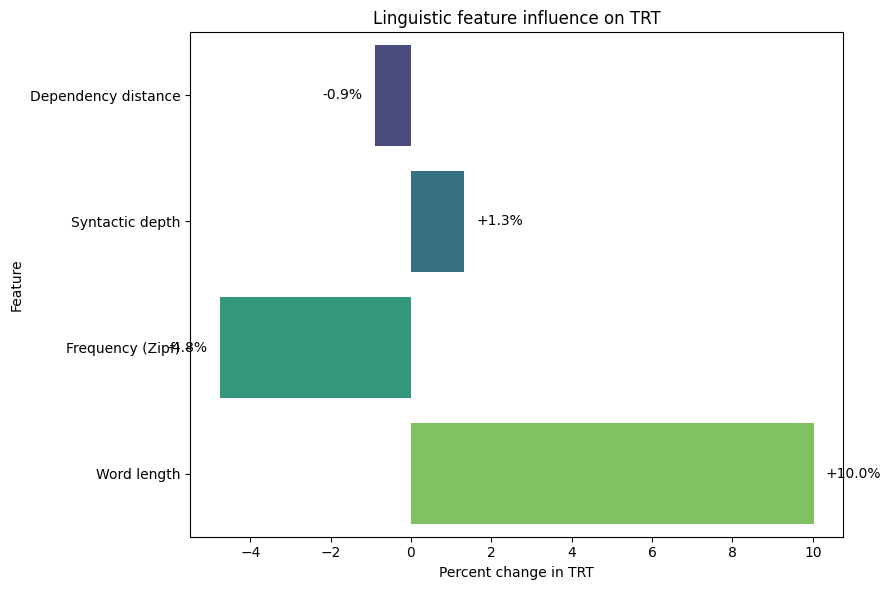

In [61]:
# Linguistic feature influence on TRT
from pathlib import Path
from IPython.display import display, Image
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

proc = Path('data-clean/processed')
saved = proc / 'report_fig_feature_effects.png'
main_csv = proc / 'report_main_feature_effects.csv'

if main_csv.exists():
    ef = pd.read_csv(main_csv)
    # Drop Integration cost rows
    ef = ef[~ef['label'].str.contains('integration', case=False, na=False)].copy()
    # Use the signed percent column
    if 'percent' not in ef.columns:
        print('Unexpected columns in feature effects table:', ef.columns.tolist())
        display(ef.head())
    else:
        ef = ef.sort_values(by='percent', key=lambda s: s.abs())
        plt.figure(figsize=(9,6))
        ax = sns.barplot(data=ef, x='percent', y='label', orient='h', palette='viridis')
        for i, row in ef.reset_index(drop=True).iterrows():
            sign = '+' if row['percent'] >= 0 else ''
            ax.text(row['percent'] + (0.3 if row['percent'] >= 0 else -0.3), i,
                    f"{sign}{row['percent']:.1f}%", va='center', ha='left' if row['percent'] >= 0 else 'right', color='black')
        ax.set_xlabel('Percent change in TRT')
        ax.set_ylabel('Feature')
        ax.set_title('Linguistic feature influence on TRT')
        plt.tight_layout()
        plt.show()
elif saved.exists():
    display(Image(filename=str(saved)))
else:
    print('Missing inputs for feature influence figure:', main_csv)

### Figure 2 — Feature means by condition 
Average feature values within each condition (neg, zero, pos).

Feature effects data shape (after filtering): (4, 7)
Columns: ['label', 'percent', 'percent_lo', 'percent_hi', 'beta', 'ci_lo', 'ci_hi']
Data:
                 label    percent  percent_lo  percent_hi      beta     ci_lo  \
0  Dependency distance  -0.904569   -1.891006    0.091786 -0.009087 -0.019091   
1     Frequency (Zipf)  -4.763248  -16.577146    8.723671 -0.048804 -0.181248   
3      Syntactic depth   1.319687    0.656600    1.987141  0.013111  0.006545   
4          Word length  10.021825   -3.785004   25.809932  0.095509 -0.038585   

      ci_hi  
0  0.000917  
1  0.083639  
3  0.019677  
4  0.229602  
Saved feature influence ranking to: data-clean\processed\report_fig_feature_influence_ranking.png
Saved feature influence ranking to: data-clean\processed\report_fig_feature_influence_ranking.png


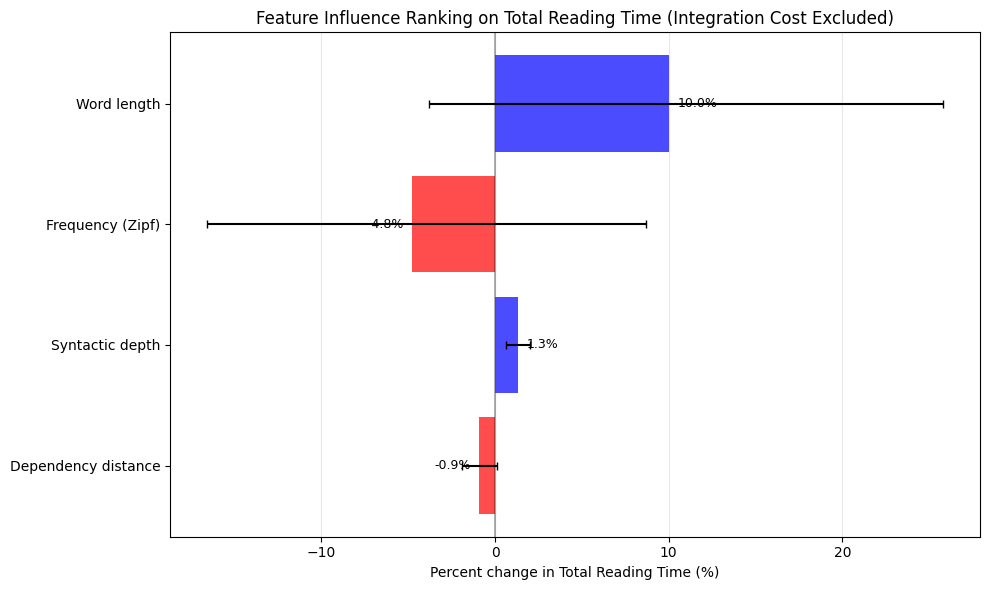

In [71]:
# Feature influence ranking on TRT
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path

# Check if we have the main feature effects table
main_csv = OUT / 'report_main_feature_effects.csv'
rank_path = OUT / 'report_fig_feature_influence_ranking.png'

if main_csv.exists():
    # Load the feature effects data
    ef = pd.read_csv(main_csv)
    
    # Filter out integration cost
    ef = ef[~ef['label'].str.contains('Integration cost', case=False, na=False)]
    
    print(f"Feature effects data shape (after filtering): {ef.shape}")
    print(f"Columns: {ef.columns.tolist()}")
    print(f"Data:\n{ef}")
    
    # Create figure
    plt.figure(figsize=(10, 6))
    
    # Sort by absolute percent change for ranking
    ef_sorted = ef.copy()
    ef_sorted['abs_percent'] = ef_sorted['percent'].abs()
    ef_sorted = ef_sorted.sort_values('abs_percent', ascending=True)
    
    # Create horizontal bar plot
    colors = ['red' if x < 0 else 'blue' for x in ef_sorted['percent']]
    bars = plt.barh(range(len(ef_sorted)), ef_sorted['percent'], color=colors, alpha=0.7)
    
    # Add error bars if confidence intervals are available
    if 'percent_lo' in ef_sorted.columns and 'percent_hi' in ef_sorted.columns:
        yerr_lo = ef_sorted['percent'] - ef_sorted['percent_lo']
        yerr_hi = ef_sorted['percent_hi'] - ef_sorted['percent']
        plt.errorbar(ef_sorted['percent'], range(len(ef_sorted)), 
                    xerr=[yerr_lo, yerr_hi], fmt='none', color='black', capsize=3)
    
    # Customize the plot
    plt.yticks(range(len(ef_sorted)), ef_sorted['label'])
    plt.xlabel('Percent change in Total Reading Time (%)')
    plt.title('Feature Influence Ranking on Total Reading Time (Integration Cost Excluded)')
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.grid(axis='x', alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars, ef_sorted['percent'])):
        plt.text(val + (0.5 if val > 0 else -0.5), i, f'{val:.1f}%', 
                ha='left' if val > 0 else 'right', va='center', fontsize=9)
    
    plt.tight_layout()
    
    # Save the figure
    plt.savefig(rank_path, dpi=300, bbox_inches='tight')
    print(f"Saved feature influence ranking to: {rank_path}")
    
    plt.show()
    
elif rank_path.exists():
    # Fallback to existing image
    from IPython.display import display, Image
    display(Image(filename=str(rank_path)))
else:
    print(f'Missing both data file ({main_csv}) and image file ({rank_path})')
    print("Please ensure the main feature effects table has been generated in the previous cell.")

### Figure 3 — Total reading time by condition
We compare neg, zero, pos (in that order) and label the values so the difference is easy to see.

C:\Users\Mert Yeşilyurt\AppData\Local\Temp\ipykernel_19668\80392128.py:31: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  ax = sns.pointplot(data=cm, x='condition', y=ycol, order=order, join=False, color='#2a5', capsize=0.2)


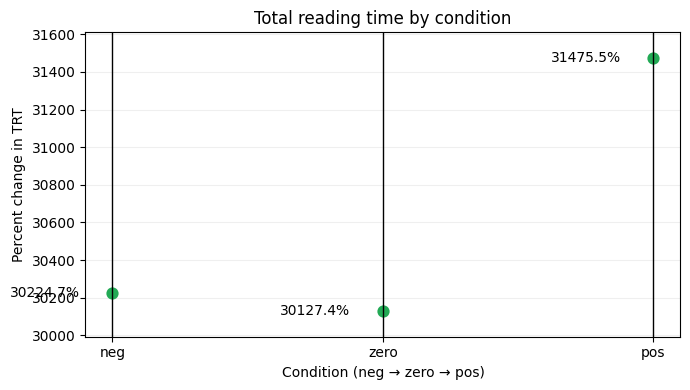

In [63]:
# Total reading time by condition (neg → zero → pos)
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Image

proc = Path('data-clean/processed')
cm_csv = proc / 'report_condition_marginal_means.csv'
cm_png = proc / 'report_fig_condition_means.png'

if cm_csv.exists():
    cm = pd.read_csv(cm_csv)
    order = ['neg','zero','pos']
    # Map expected columns
    if 'pct' in cm.columns:
        ycol = 'pct'; lo_col = 'lo'; hi_col = 'hi'; units = '%'
    elif 'pct_mean' in cm.columns and 'pct_ci_lo' in cm.columns and 'pct_ci_hi' in cm.columns:
        ycol = 'pct_mean'; lo_col = 'pct_ci_lo'; hi_col = 'pct_ci_hi'; units = '%'
    elif 'mean' in cm.columns and 'lo' in cm.columns and 'hi' in cm.columns:
        ycol = 'mean'; lo_col = 'lo'; hi_col = 'hi'; units = 'ms'
    else:
        print('Unexpected columns in condition means table:', cm.columns.tolist())
        display(cm.head())
        raise SystemExit()

    # Ensure correct ordering
    cm = cm.set_index('condition').loc[order].reset_index()

    plt.figure(figsize=(7,4))
    ax = sns.pointplot(data=cm, x='condition', y=ycol, order=order, join=False, color='#2a5', capsize=0.2)

    # Error bars if present
    if lo_col in cm.columns and hi_col in cm.columns:
        for i, row in cm.iterrows():
            ax.vlines(i, row[lo_col], row[hi_col], colors='black', lw=1)

    # Place numeric labels to the left of each marker for readability
    vmin, vmax = cm[ycol].min(), cm[ycol].max()
    span = max(1e-9, vmax - vmin)
    for i, row in cm.iterrows():
        val = row[ycol]
        if units == '%':
            label = f"{val:.1f}%"
        else:
            label = f"{val:.0f} ms"
        ax.text(i - 0.12, val, label, ha='right', va='center', fontsize=10, color='black')

    ax.set_ylim(vmin - 0.1*span, vmax + 0.1*span)
    ax.set_title('Total reading time by condition')
    ax.set_xlabel('Condition (neg → zero → pos)')
    ax.set_ylabel('Percent change in TRT' if units=='%' else 'TRT (ms)')
    ax.grid(axis='y', alpha=0.2)
    plt.tight_layout()
    plt.show()
elif cm_png.exists():
    display(Image(filename=str(cm_png)))
else:
    print('Missing inputs for condition means figure:', cm_csv)

### Figure 4 — Which linguistic features explain TRT
We show each feature’s modeled influence on total reading time (percent change), excluding Integration cost.

Loading wide format data from: data-clean\processed\report_feature_condition_descriptives_wide.csv
Wide data columns: ['feature', 'neg', 'zero', 'pos']
Wide data shape: (5, 4)
First few rows:
            feature       neg      zero       pos
0          dep_dist  2.449349  2.347391  2.339787
1             depth  2.401642  2.138148  1.926000
2         freq_zipf  7.519768  7.205190  6.395608
3  integration_cost  1.252029  1.174212  1.108051
4          word_len  4.468247  5.013411  6.284422
Saved heatmap to: data-clean\processed\report_fig_feature_means_heatmap_ordered.png
Saved heatmap to: data-clean\processed\report_fig_feature_means_heatmap_ordered.png


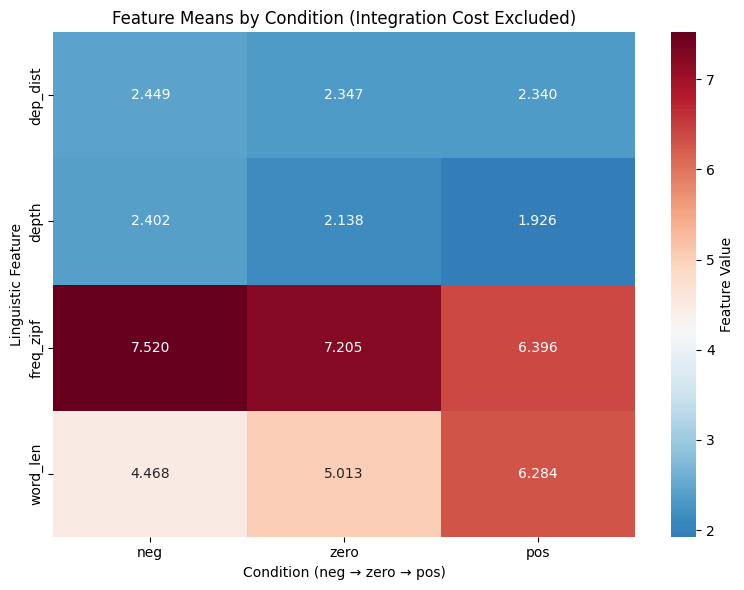

In [70]:
# Feature means by condition heatmap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

proc = PROC
ordered_png = proc / 'report_fig_feature_means_heatmap_ordered.png'
descriptives_path = proc / 'feature_condition_descriptives.csv'
wide_path = proc / 'report_feature_condition_descriptives_wide.csv'

# Try to generate the heatmap from available data
fig_generated = False

# First try: use the wide format if available
if wide_path.exists():
    print(f"Loading wide format data from: {wide_path}")
    wide = pd.read_csv(wide_path)
    print(f"Wide data columns: {wide.columns.tolist()}")
    print(f"Wide data shape: {wide.shape}")
    print(f"First few rows:\n{wide.head()}")
    
    # Check for condition columns
    condition_cols = [c for c in wide.columns if c in {'neg','zero','pos'}]
    if len(condition_cols) >= 2 and 'feature' in wide.columns:
        # Filter out integration cost if present
        df = wide[['feature'] + condition_cols].copy()
        df = df[~df['feature'].str.contains('integration', case=False, na=False)]
        
        # Create pivot table for heatmap
        df_plot = df.set_index('feature')
        order = [c for c in ['neg','zero','pos'] if c in condition_cols]
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(df_plot[order], annot=True, fmt='.3f', cmap='RdBu_r', 
                   center=df_plot.values.mean(), cbar_kws={'label': 'Feature Value'})
        plt.title('Feature Means by Condition (Integration Cost Excluded)')
        plt.ylabel('Linguistic Feature')
        plt.xlabel('Condition (neg → zero → pos)')
        plt.tight_layout()
        
        # Save the figure
        plt.savefig(ordered_png, dpi=300, bbox_inches='tight')
        print(f"Saved heatmap to: {ordered_png}")
        
        plt.show()
        fig_generated = True

# Second try: use the long format descriptives
elif descriptives_path.exists():
    print(f"Loading descriptives data from: {descriptives_path}")
    desc = pd.read_csv(descriptives_path)
    print(f"Descriptives columns: {desc.columns.tolist()}")
    print(f"Descriptives shape: {desc.shape}")
    print(f"First few rows:\n{desc.head()}")
    
    # Check if we can create a pivot table
    if {'feature', 'condition', 'mean'}.issubset(desc.columns):
        # Filter out integration cost if present
        desc_filtered = desc[~desc['feature'].str.contains('integration', case=False, na=False)]
        
        # Create pivot table
        heatmap_data = desc_filtered.pivot(index='feature', columns='condition', values='mean')
        
        # Ensure proper column ordering
        order = [c for c in ['neg','zero','pos'] if c in heatmap_data.columns]
        if len(order) >= 2:
            plt.figure(figsize=(8, 6))
            sns.heatmap(heatmap_data[order], annot=True, fmt='.3f', cmap='RdBu_r', 
                       center=heatmap_data.values.mean(), cbar_kws={'label': 'Feature Value'})
            plt.title('Feature Means by Condition (Integration Cost Excluded)')
            plt.ylabel('Linguistic Feature')
            plt.xlabel('Condition (neg → zero → pos)')
            plt.tight_layout()
            
            # Save the figure
            plt.savefig(ordered_png, dpi=300, bbox_inches='tight')
            print(f"Saved heatmap to: {ordered_png}")
            
            plt.show()
            fig_generated = True

# Third try: generate from available feature data if we have it
if not fig_generated and 'feat_desc' in globals():
    print("Using feat_desc variable from previous processing")
    print(f"feat_desc columns: {feat_desc.columns.tolist()}")
    print(f"feat_desc shape: {feat_desc.shape}")
    
    if {'feature', 'condition', 'mean'}.issubset(feat_desc.columns):
        # Filter out integration cost if present
        desc_filtered = feat_desc[~feat_desc['feature'].str.contains('integration', case=False, na=False)]
        
        # Create pivot table
        heatmap_data = desc_filtered.pivot(index='feature', columns='condition', values='mean')
        
        # Ensure proper column ordering
        order = [c for c in ['neg','zero','pos'] if c in heatmap_data.columns]
        if len(order) >= 2:
            plt.figure(figsize=(8, 6))
            sns.heatmap(heatmap_data[order], annot=True, fmt='.3f', cmap='RdBu_r', 
                       center=heatmap_data.values.mean(), cbar_kws={'label': 'Feature Value'})
            plt.title('Feature Means by Condition (Integration Cost Excluded)')
            plt.ylabel('Linguistic Feature')
            plt.xlabel('Condition (neg → zero → pos)')
            plt.tight_layout()
            
            # Save the figure
            plt.savefig(ordered_png, dpi=300, bbox_inches='tight')
            print(f"Saved heatmap to: {ordered_png}")
            
            plt.show()
            fig_generated = True

# Fallback: try to display existing images
if not fig_generated:
    from IPython.display import display, Image
    
    if ordered_png.exists():
        print("Displaying existing ordered heatmap")
        display(Image(filename=str(ordered_png)))
    else:
        default_png = proc / 'report_fig_feature_means_heatmap.png'
        if default_png.exists():
            print("Displaying existing default heatmap")
            display(Image(filename=str(default_png)))
        else:
            print(f'Could not generate or find heatmap. Checked paths:')
            print(f'- Wide format: {wide_path} (exists: {wide_path.exists()})')
            print(f'- Descriptives: {descriptives_path} (exists: {descriptives_path.exists()})')
            print(f'- Ordered PNG: {ordered_png} (exists: {ordered_png.exists()})')
            print(f'- Default PNG: {default_png} (exists: {default_png.exists()})')
            
            # Show available files in the processed directory
            if proc.exists():
                print(f"\nAvailable files in {proc}:")
                for f in sorted(proc.glob("*feature*")):
                    print(f"  {f.name}")
            else:
                print(f"Processed directory {proc} does not exist")

## Discussion and conclusion

As in the previous studies’ results, frequency showed a negative effect while word length showed a positive effect for TRT, aligning with prior work on eye movements in reading (Rayner, 1998; Kliegl, Nuthmann, & Engbert, 2006). Syntactic depth also offers a positive effect, which is in the same direction as the previous findings (Gibson, 2000). However, dependency distances show a negative effect, which doesn’t completely align with the literature findings (Gibson, 2000). This change might arise from a problem with the pipeline. However, it could also be due to the text's nature of being generated. It might be that language models might utilize dependency distances better than human-generated texts, yet without further research, this can only stay as a hypothesis since it still remains not thoroughly tested in this study.
As expected from previous findings, lexical features affect TRT considerably more than syntactical features (Rayner, 1998; Kliegl et al., 2006). Word length and then the frequency are shown to be the strongest features, while syntactic depth and dependency distance follow them, with syntactic depth offering a slight advantage over dependency distance.
Surprisingly, in the total reading time by condition ranking, zero has the first place with the lowest score, which is followed by the negative with only a small difference. The last place is positive, as would have been expected, since it aims for longer reading time. The results of the zero might indicate that while generating texts, language models may already aim to create texts that are easy to read- even without the influence of a gaze model or a specific prompt. Therefore, having an even better score than the negative condition texts that were specifically designed to be easier to read.
The effects of the linguistic features on gaze conditions show a nearly stable distribution among the conditions, except for the dependency distance feature. The contradictory results of the dependency distance feature might indicate a problem in the pipeline. Other than that dependency, for other features, the distribution of feature effects is either followed as negative to zero to positive, or from positive to zero to negative. This might imply the systematic structures of each text type/condition. Also, as expected, and proved by the earlier studies, the negative condition, which aims for faster reading, proves to have the highest word frequency and lower word length compared to the other two conditions (Rayner, 1998; Kliegl et al., 2006). 
Surprisingly, although a higher syntactic depth score should indicate longer reading (Gibson, 2000), the results seem to show the opposite. This might, of course, indicate an error in the pipeline; however, it might also display a characteristic of a generated text. Due to its abilities, a model might utilize the longer syntactic depth better than a human; therefore, it might utilize sentences with lower syntactic depth to disrupt the flow of reading while utilizing higher syntactic level sentences to not interrupt the reading with stops or transitions to new sentences. Yet again, with the data at hand, this cannot be proven without further investigation, and it might also be mostly influenced by punctuation or other features. Nevertheless, from the data we have at hand, we can claim that lexical features affect the TRT more than syntactical features.

Overall, our results show that lexical features affect total reading time more than syntactical features. It confirms the hypothesis that higher frequency levels will lead to shorter total reading time, while, on the other hand, longer words will lead to longer total reading time. Although it was able to prove that greater syntactic depth will lead to longer total reading time, it fails to find the evidence to prove that longer dependencies lead to longer reading time, as the feature offers a negative score. For the gaze conditions, it successfully shows that the positive gaze condition leads to features that increase the reading time, while the negative gaze condition leads to a decrease in the reading time. However, while the lexical features show a correspondence with the expected influence on the gaze conditions, syntactic features show the opposite effect than expected.


# AI usage declaration

I used the following tools:

| Tool           | Purpose                                              |
| -------------- | -----------------------------------------------------|
| ChatGPT        | Brainstorming research questions & literature review |
| GitHub Copilot | Assistance with plotting code                        |
| Grammarly      | Grammar checking                                     |


- I thoroughly checked all output generated by these tools.
- I know that I am responsible for the correctness of all code and content in this report.
- I confirm that (apart from the resources listed above) the code and content in this report is my own work.

**Signature:** Mert Yeşilyurt


## References

Baayen, R. H., Davidson, D. J., & Bates, D. M. (2008). Mixed-effects modeling with crossed random effects for subjects and items. *Journal of Memory and Language, 59*(4), 390–412. 

Chomsky, N. (1957). *Syntactic structures*. The Hague, Netherlands: Mouton.

Fodor, J. A. (1983). *The modularity of mind*. Cambridge, MA: MIT Press.

Gibson, E. (2000). The dependency locality theory: A distance-based theory of linguistic complexity. In Y. Miyashita, A. Marantz, & W. O’Neil (Eds.), *Image, language, brain* (pp. 95–126). Cambridge, MA: MIT Press.

Grodner, D., & Gibson, E. (2005). Consequences of the serial nature of linguistic input for sentential complexity. *Cognitive Science, 29*(2), 261–290. 

Kliegl, R., Nuthmann, A., & Engbert, R. (2006). Tracking the mind during reading: The influence of past, present, and future words on fixation durations. *Journal of Experimental Psychology: General, 135*(1), 12–35. 

Rayner, K. (1998). Eye movements in reading and information processing: 20 years of research. *Psychological Bulletin, 124*(3), 372–422.